# Imports

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.colors as colors
from matplotlib import cm as cmm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Times New Roman"
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
matplotlib.rcParams['text.usetex'] = True
import numpy as np
from pyhdf.SD import SD, SDC
import glob
from sklearn import cluster
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity as ssim
import random
import pickle
import sunpy.time
from astropy.time import Time
import sunpy.visualization.colormaps as cm
import skimage.segmentation as segmentation
import skimage.measure
import h5py

# Functions 

In [2]:
# Metric of success
def intersection_union(img1, img2):
    # Intersection over Union calculation
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou_score = np.sum(intersection) / np.sum(union)
  
    return iou_score

# Read in hdf files
def read_hdf(filename, hdf_key='Data-Set-2'):
    
    hdf = SD(filename, SDC.READ)
    hdf_data = hdf.select(hdf_key)
    hdf_img= hdf_data.get()

    return hdf_img

# K-means predictions (after training)
def make_kmeans_prediction(kmeans, euv_data, lower_threshold=0):
    
    # Original dimensions
    nx, ny = euv_data.shape
    
    # Identify positive pixels
    euv_data = np.reshape(euv_data, (nx*ny, 1))
    where_pos = np.where(euv_data > lower_threshold)
    nb_pix = len(where_pos[0])
    euv_data = np.reshape(euv_data[where_pos], (nb_pix, 1))
  
    # Kmeans
    kmeans_predict = kmeans.predict(euv_data)
    clusters_predict = np.zeros((nx*ny, 1))-1
    clusters_predict[where_pos] = kmeans_predict
    clusters_predict = np.reshape(clusters_predict, (nx, ny))
    
    return clusters_predict

# Function to calculate number of coronal holes pixels in each band of an hdf image
def compute_nb(img, deg=50):
    
    if(deg != 0):
    
        # Dimensions
        nx, ny = img.shape
        nb_pix = int(np.round(nx/180.*(90.-deg)))
    
        # Compute area fraction
        n_area = np.count_nonzero(img[nx-nb_pix:nx, :])  # /(nb_pix*ny)
        s_area = np.count_nonzero(img[0:nb_pix, :])  # /(nb_pix*ny)
        c_area = np.count_nonzero(img[nb_pix:nx-nb_pix, :])  # /((nx-2*nb_pix)*ny)
        
        return n_area, s_area, c_area
    
    elif(deg == 0):
    
        # Dimensions
        nx, ny = img.shape
    
        # Compute area fraction
        n_hemisphere = np.count_nonzero(img[nx-int(np.round(0.5*nx)):nx, :])  # /(0.5*nx*ny)
        s_hemisphere = np.count_nonzero(img[0:int(np.round(0.5*nx)), :])  # /(0.5*nx*ny)
    
        return n_hemisphere, s_hemisphere

    
# Compare prediction to reference (PSI mask)
# To be implemented to replace old version.
def prediction_metrics(ch_pred, ch_ref, euv_ref, euv_lower_threshold=-100, reduction=1):
    
    # Metrics (array):
    # 0: SSIM (including missing data)
    # 1: IoU (including missing data)
    # 2: SSIM (excluding missing data)
    # 3: IoU (excluding missing data)
    # 4: Nb. of pixels labeled as CHs (North pole; latitude > 55 degrees)
    # 5: Nb. of pixels labeled as CHs (South pole; latitude < -55 degrees)
    # 6: Nb. of pixels labeled as CHs (Center; -55 < latitude < 55 degrees)
    # 7: Nb. of pixels labeled as CHs (North pole; latitude > 50 degrees)
    # 8: Nb. of pixels labeled as CHs (South pole; latitude < -50 degrees)
    # 9: Nb. of pixels labeled as CHs (Center; -50 < latitude < 50 degrees)
    #10: Nb. of pixels labeled as CHs (Northern hemisphere; latitude > 0 degrees)
    #11: Nb. of pixels labeled as CHs (Southern hemisphere; latitude < 0 degrees)
    #12: Nb. of good pixels (North pole; latitude > 55 degrees)
    #13: Nb. of good pixels (South pole; latitude < -55 degrees)
    #14: Nb. of good pixels (Center; -55 < latitude < 55 degrees)
    #15: Nb. of good pixels (North pole; latitude > 50 degrees)
    #16: Nb. of good pixels (South pole; latitude < -50 degrees)
    #17: Nb. of good pixels (Center; -50 < latitude < 50 degrees)
    #18: Nb. of good pixels (Northern hemisphere; latitude > 0 degrees)
    #19: Nb. of good pixels (Southern hemisphere; latitude < 0 degrees)
    #20: Nb. of bad pixels (North pole; latitude > 55 degrees)
    #21: Nb. of bad pixels (South pole; latitude < -55 degrees)
    #22: Nb. of bad pixels (Center; -55 < latitude < 55 degrees)
    #23: Nb. of bad pixels (North pole; latitude > 50 degrees)
    #24: Nb. of bad pixels (South pole; latitude < -50 degrees)
    #25: Nb. of bad pixels (Center; -50 < latitude < 50 degrees)
    #26: Nb. of bad pixels (Northern hemisphere; latitude > 0 degrees)
    #27: Nb. of bad pixels (Southern hemisphere; latitude < 0 degrees)
    
    # Metrics array
    metrics = np.zeros(28)
    
    # Reference EUV data
    # Adjust spatial resolution
    if(reduction > 1):
        euv_ref = skimage.measure.block_reduce(euv_ref, (reduction, reduction), np.nanmin)
    # Identify where pixel values reach -9999
    where_goodpix = np.where(euv_ref > euv_lower_threshold)
    where_badpix = np.where(euv_ref < euv_lower_threshold)
    
    # Reference CH masks 
    # PSI: 0 = No CH, 1-9 = Varying levels of quality, 10 = Missing data
    # Reference: http://www.predsci.com/chd/chd_maps.html
    ch_ref = np.where((ch_ref > 0) & (ch_ref < 10), 1., 0.)
    # Adjust spatial resolution
    if(reduction > 1):
        # Note. np.nanmin will favor less CHs.
        ch_ref = skimage.measure.block_reduce(ch_ref, (reduction, reduction), np.nanmin)
    
    # Compute metrics
    metrics[0] = ssim(ref_data, clusters, data_range=ref_data.max() - ref_data.min())
    metrics[1] = intersection_union(ref_data, clusters)
    metrics[2] = ssim(ref_data[where_goodpix], clusters[where_goodpix], data_range=ref_data[where_goodpix].max() - ref_data[where_goodpix].min())
    metrics[3] = intersection_union(ref_data[where_goodpix], clusters[where_goodpix])
    metrics[4], metrics[5], metrics[6] = compute_nb(clusters, deg=50)
    metrics[7], metrics[8], metrics[9] = compute_nb(clusters, deg=55)
    metrics[10], metrics[11] = compute_nb(clusters, deg=0)
    # Good pixels only
    goodpix = np.zeros((nx_w, ny_w))
    goodpix[where_goodpix] = 1 
    metrics[12], metrics[13], metrics[14] = compute_nb(goodpix, deg=50)
    metrics[15], metrics[16], metrics[17] = compute_nb(goodpix, deg=55)
    metrics[18], metrics[19] = compute_nb(goodpix, deg=0)
    # Bad pixels only
    badpix = np.zeros((nx_w, ny_w))
    badpix[where_badpix] = 1 
    metrics[20], metrics[21], metrics[22] = compute_nb(badpix, deg=50)
    metrics[23], metrics[24], metrics[25] = compute_nb(badpix, deg=55)
    metrics[26], metrics[27] = compute_nb(badpix, deg=0)
    
    return metrics


# Data

### Read PSI images and W-net predictions (K-means predictions are made on the fly):

In [4]:
# Filename patterns 
path_euv = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_*'
path_chm = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/chm/maps_r101_chm_*'
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/Wnet_SEARCH/output/maps*'
filenames_euv = sorted(glob.glob(path_euv))
filenames_chm = sorted(glob.glob(path_chm))

# EUV and CHM data
euv_key = 'Data-Set-2'
chm_key = 'Data-Set-2'
# Sine-latitude (sine(radians))
lat_key = 'fakeDim0'
# Longitude (radians)
long_key = 'fakeDim1'
# Image dimensions
nx = 1600
ny = 3200

### List of dates/times corresponding to the PSI images:

In [ ]:
# List of times of the PSI database
filename = 'euvchm_map_list.npz'
tmp = np.load(filename)
caplan_labels = tmp['caplan_labels'] 
caplan_times = tmp['caplan_times']
caplan_nb = len(caplan_times)

# Initial time
t0 = Time('2010-01-01T00:00:00').utime
# Convert to floats
caplan_t = np.zeros((caplan_nb))
for i in range(caplan_nb):
    caplan_t[i] = Time(caplan_times[i]).utime-t0

# K-Means: Training & Predictions

## Training: 

In [4]:
# Training
size_train = 15
n_clusters = 6
lower_threshold = -100
train_set = np.zeros((size_train, nx, ny))

# Shuffle list of file numbers (e.g, file #0, file #1, etc.)
filenames_euv_shuffled, filenames_chm_shuffled = shuffle(filenames_euv[2000:], filenames_chm[2000:], random_state=0)
filenames_euv_train = filenames_euv_shuffled[0:size_train]

# Fill train set
for i in range(size_train):
    print(filenames_euv_train[i])
    train_set[i, :, :] = read_hdf(filenames_euv_train[i])

# Reshape euv images to (pixel area * nb_files, 1)
ii = np.where(train_set > lower_threshold)
nb_ii = len(ii[0])
train_set = np.reshape(train_set[ii], (nb_ii, 1))

# Run Kmeans on the euv_img_reshape array
kmeans = cluster.KMeans(n_clusters = n_clusters, random_state=0).fit(train_set)
pickle.dump(kmeans, open("save_Kmeans_lb_15i_6c.pkl", "wb"))

/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_4231.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_2669.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_5621.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_4364.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_2143.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_2539.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_3792.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_2411.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_3151.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/maps_r101_euv_3033.hdf
/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/euv/

## Predictions:

### Computing metrics over the entire dataset (in order to study time evolution):

In [119]:
# Retrieve Kmeans from pickle
kmeans = pickle.load(open("save_Kmeans_lb_15i_6c.pkl", "rb"))
ch_cluster = 3
lower_threshold = -100.

# Files to read
file_start = 0
file_end = len(filenames_euv)

# Arrays
ssim_arr = np.zeros((file_end-file_start))
iou_arr = np.zeros((file_end-file_start))
ssim_filt_arr = np.zeros((file_end-file_start))
iou_filt_arr = np.zeros((file_end-file_start))
n_goodpix_50deg = np.zeros((file_end-file_start))
n_badpix_50deg = np.zeros((file_end-file_start))
s_goodpix_50deg = np.zeros((file_end-file_start))
s_badpix_50deg = np.zeros((file_end-file_start))
c_goodpix_50deg = np.zeros((file_end-file_start))
c_badpix_50deg = np.zeros((file_end-file_start))
n_goodpix_55deg = np.zeros((file_end-file_start))
n_badpix_55deg = np.zeros((file_end-file_start))
s_goodpix_55deg = np.zeros((file_end-file_start))
s_badpix_55deg = np.zeros((file_end-file_start))
c_goodpix_55deg = np.zeros((file_end-file_start))
c_badpix_55deg = np.zeros((file_end-file_start))
n_hemisphere_goodpix = np.zeros((file_end-file_start))
n_hemisphere_badpix = np.zeros((file_end-file_start))
s_hemisphere_goodpix = np.zeros((file_end-file_start))
s_hemisphere_badpix = np.zeros((file_end-file_start))
n_50deg = np.zeros((file_end-file_start))
s_50deg = np.zeros((file_end-file_start))
c_50deg = np.zeros((file_end-file_start))
n_55deg = np.zeros((file_end-file_start))
s_55deg = np.zeros((file_end-file_start))
c_55deg = np.zeros((file_end-file_start))
n_hemisphere = np.zeros((file_end-file_start))
s_hemisphere = np.zeros((file_end-file_start))
caplan_n_50deg = np.zeros((file_end-file_start))
caplan_s_50deg = np.zeros((file_end-file_start))
caplan_c_50deg = np.zeros((file_end-file_start))
caplan_n_55deg = np.zeros((file_end-file_start))
caplan_s_55deg = np.zeros((file_end-file_start))
caplan_c_55deg = np.zeros((file_end-file_start))
caplan_n_hemisphere = np.zeros((file_end-file_start))
caplan_s_hemisphere = np.zeros((file_end-file_start))

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):
  
    # Read EUV data
    ref_data = read_hdf(filenames_euv[i]).astype(float)
    where_goodpix = np.where(ref_data > lower_threshold)
    where_badpix = np.where(ref_data < lower_threshold)
    # Make Kmeans prediciton
    clusters = make_kmeans_prediction(kmeans, ref_data, lower_threshold=lower_threshold)
    # Extract CHs
    clusters = np.where(clusters == ch_cluster, 1., 0.)
    
    # Compare to Caplan CH masks 
    ref_data = read_hdf(filenames_chm[i]).astype(float)
    ref_data = np.where((ref_data > 0) & (ref_data < 10), 1., 0.)
    # Compute metrics
    ssim_arr[i-file_start] = ssim(ref_data, clusters, data_range=ref_data.max() - ref_data.min())
    iou_arr[i-file_start] = intersection_union(ref_data, clusters)
    ssim_filt_arr[i-file_start] = ssim(ref_data[where_goodpix], clusters[where_goodpix], data_range=ref_data[where_goodpix].max() - ref_data[where_goodpix].min())
    iou_filt_arr[i-file_start] = intersection_union(ref_data[where_goodpix], clusters[where_goodpix])
    
    # Compute area for the North/South poles and hemispheres
    n_50deg[i-file_start], s_50deg[i-file_start], c_50deg[i-file_start] = compute_nb(clusters, deg=50)
    n_55deg[i-file_start], s_55deg[i-file_start], c_55deg[i-file_start] = compute_nb(clusters, deg=55)
    n_hemisphere[i-file_start], s_hemisphere[i-file_start] = compute_nb(clusters, deg=0)
    arr = np.zeros((nx, ny))
    arr[where_goodpix] = 1 
    n_goodpix_50deg[i-file_start], s_goodpix_50deg[i-file_start], c_goodpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_goodpix_55deg[i-file_start], s_goodpix_55deg[i-file_start], c_goodpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_goodpix[i-file_start], s_hemisphere_goodpix[i-file_start] = compute_nb(arr, deg=0)
    arr = np.zeros((nx, ny))
    arr[where_badpix] = 1 
    n_badpix_50deg[i-file_start], s_badpix_50deg[i-file_start], c_badpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_badpix_55deg[i-file_start], s_badpix_55deg[i-file_start], c_badpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_badpix[i-file_start], s_hemisphere_badpix[i-file_start] = compute_nb(arr, deg=0)
    caplan_n_50deg[i-file_start], caplan_s_50deg[i-file_start], caplan_c_50deg[i-file_start] = compute_nb(ref_data, deg=50)
    caplan_n_55deg[i-file_start], caplan_s_55deg[i-file_start], caplan_c_55deg[i-file_start] = compute_nb(ref_data, deg=55)
    caplan_n_hemisphere[i-file_start], caplan_s_hemisphere[i-file_start] = compute_nb(ref_data, deg=0)

filename = 'Kmeans_lb_15i_6c_metrics.npz'
np.savez(filename, ssim_arr=ssim_arr, iou_arr=iou_arr, ssim_filt_arr=ssim_filt_arr, iou_filt_arr=iou_filt_arr, 
         n_50deg=n_50deg, s_50deg=s_50deg, c_50deg=c_50deg, 
         n_55deg=n_55deg, s_55deg=s_55deg, c_55deg=c_55deg, 
         n_hemisphere=n_hemisphere, s_hemisphere=s_hemisphere,
         n_badpix_50deg=n_badpix_50deg, s_badpix_50deg=s_badpix_50deg, c_badpix_50deg=c_badpix_50deg,
         n_badpix_55deg=n_badpix_55deg, s_badpix_55deg=s_badpix_55deg, c_badpix_55deg=c_badpix_55deg, 
         n_hemisphere_badpix=n_hemisphere_badpix, s_hemisphere_badpix=s_hemisphere_badpix,
         n_goodpix_50deg=n_goodpix_50deg, s_goodpix_50deg=s_goodpix_50deg, c_goodpix_50deg=c_goodpix_50deg,
         n_goodpix_55deg=n_goodpix_55deg, s_goodpix_55deg=s_goodpix_55deg, c_goodpix_55deg=c_goodpix_55deg, 
         n_hemisphere_goodpix=n_hemisphere_goodpix, s_hemisphere_goodpix=s_hemisphere_goodpix,
         caplan_n_50deg=caplan_n_50deg, caplan_s_50deg=caplan_s_50deg, caplan_c_50deg=caplan_c_50deg, 
         caplan_n_55deg=caplan_n_55deg, caplan_s_55deg=caplan_s_55deg, caplan_c_55deg=caplan_c_55deg, 
         caplan_n_hemisphere=caplan_n_hemisphere, caplan_s_hemisphere=caplan_s_hemisphere)

750 0.8836507853827893 0.557010531725648 0.9321101925813592 0.6382098150868716
1117509.0 1118620.0 2787818.0
976262.0 977316.0 3070369.0
21691.0 20580.0 53782.0
18938.0 17884.0 59231.0
751 0.8871038396736791 0.5665976029792875 0.9353125222555044 0.649845424079001
1117485.0 1118601.0 2787770.0
976241.0 977300.0 3070315.0
21715.0 20599.0 53830.0
18959.0 17900.0 59285.0
752 0.8946406911764622 0.5864651672216752 0.9419267145884191 0.6758171621989875
1117591.0 1118732.0 2788072.0
976332.0 977415.0 3070648.0
21609.0 20468.0 53528.0
18868.0 17785.0 58952.0


"    \n# filename = 'Kmeans_metricss.npz'\nfilename = 'Kmeans_lb_15i_6c_metrics.npz'\nnp.savez(filename, ssim_arr=ssim_arr, iou_arr=iou_arr, ssim_filt_arr=ssim_filt_arr, iou_filt_arr=iou_filt_arr, \n         n_50deg=n_50deg, s_50deg=s_50deg, c_50deg=c_50deg, \n         n_55deg=n_55deg, s_55deg=s_55deg, c_55deg=c_55deg, \n         n_hemisphere=n_hemisphere, s_hemisphere=s_hemisphere,\n         n_badpix_50deg=n_badpix_50deg, s_badpix_50deg=s_badpix_50deg, c_badpix_50deg=c_badpix_50deg,\n         n_badpix_55deg=n_badpix_55deg, s_badpix_55deg=s_badpix_55deg, c_badpix_55deg=c_badpix_55deg, \n         n_hemisphere_badpix=n_hemisphere_badpix, s_hemisphere_badpix=s_hemisphere_badpix,\n         n_goodpix_50deg=n_goodpix_50deg, s_goodpix_50deg=s_goodpix_50deg, c_goodpix_50deg=c_goodpix_50deg,\n         n_goodpix_55deg=n_goodpix_55deg, s_goodpix_55deg=s_goodpix_55deg, c_goodpix_55deg=c_goodpix_55deg, \n         n_hemisphere_goodpix=n_hemisphere_goodpix, s_hemisphere_goodpix=s_hemisphere_goodpix,\

### Retrieve single image and extract CHs and ARs:

In [4]:
# Retrieve Kmeans from pickle
kmeans = pickle.load(open("save_Kmeans_lb_15i_6c.pkl", "rb"))
ar_cluster = 2
ch_cluster = 3
lower_threshold = -100.

# Files to read
file_start = 2555
file_end = 2556

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):
  
    # Read EUV data
    ref_data = read_hdf(filenames_euv[i]).astype(float)
    where_goodpix = np.where(ref_data > lower_threshold)
    where_badpix = np.where(ref_data < lower_threshold)
    # Make Kmeans prediciton
    clusters = make_kmeans_prediction(kmeans, ref_data, lower_threshold=lower_threshold)
    # Extract CHs
    chs = np.where(clusters == ch_cluster, 1., 0.)
    ars = np.where(clusters == ar_cluster, 1., 0.)

### Plot synchronic map with CHs and ARs boundaries overplotted:

nan nan


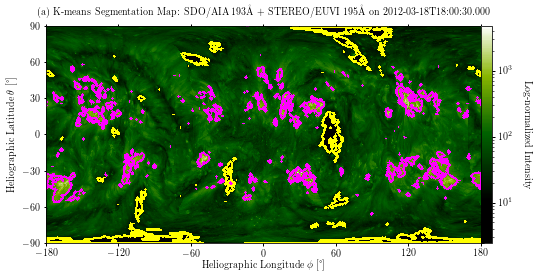

In [11]:
# Figure
frame = 0
font_size = 10
figsize_x = 8.0
figsize_y = 4.0
x_label = r'Heliographic Longitude $\phi$ [°]'
y_label = r'Heliographic Latitude $\theta$ [°]'
colorbar_cmap = plt.get_cmap('sohoeit195')  # 'eit195' # 'GnBu_r'
colorbar_label = r'Log-normalized Intensity'
# title_label = 'IBIS'
plt.rcParams["font.family"] = "Times New Roman"

x = np.linspace(0, 360.0, ny)-180.0
y = np.linspace(0, 180.0, nx)-90.0
print(np.amin(ref_data), np.amax(ref_data))
ref_data[where_badpix] = np.nan

vmin = np.nanmin(10.**ref_data)
vmax = np.nanmax(10.**ref_data)
ref_data_w = 10.**ref_data

masked = np.ma.masked_where(clusters == 0, clusters)
# print(np.amin(ref_data), np.amax(ref_data))

thickness = 10
z = np.zeros((nx, ny))
output = np.zeros((nx, ny))
arr = chs
for i in range(1, thickness):
    xp = np.concatenate((z[:i, :], arr[0:nx-i, :]), axis=0)
    xm = np.concatenate((arr[i:, :], z[nx-i:, :]), axis=0)
    yp = np.concatenate((z[:, :i], arr[:, 0:ny-i]), axis=1)
    ym = np.concatenate((arr[:, i:], z[:, ny-i:]), axis=1)
    ii = np.where(arr + xp == 1)
    output[ii] = 1
    ii = np.where(arr + xm == 1)
    output[ii] = 1
    ii = np.where(arr + yp == 1)
    output[ii] = 1
    ii = np.where(arr + ym == 1)
    output[ii] = 1
chs_masked = np.ma.masked_where(output == 0, output)

z = np.zeros((nx, ny))
output = np.zeros((nx, ny))
arr = ars
for i in range(1, thickness):
    xp = np.concatenate((z[:i, :], arr[0:nx-i, :]), axis=0)
    xm = np.concatenate((arr[i:, :], z[nx-i:, :]), axis=0)
    yp = np.concatenate((z[:, :i], arr[:, 0:ny-i]), axis=1)
    ym = np.concatenate((arr[:, i:], z[:, ny-i:]), axis=1)
    ii = np.where(arr + xp == 1)
    output[ii] = 1
    ii = np.where(arr + xm == 1)
    output[ii] = 1
    ii = np.where(arr + yp == 1)
    output[ii] = 1
    ii = np.where(arr + ym == 1)
    output[ii] = 1
ars_masked = np.ma.masked_where(output == 0, output)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x, figsize_y))
I = ax.imshow(ref_data_w, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax))   
I2 = ax.imshow(chs_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
I3 = ax.imshow(ars_masked, extent=[min(x), max(x), min(y), max(y)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
ax.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
ax.set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
ax.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
ax.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
ax.get_xaxis().set_major_locator(plt.MultipleLocator(60))
ax.get_yaxis().set_major_locator(plt.MultipleLocator(30))
# Title
ax.set_title(r'(a) K-means Segmentation Map: SDO/AIA 193Å + STEREO/EUVI 195Å on '+caplan_times[file_start], fontsize=font_size, y=1.02, wrap=True)
# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0)
cb = colorbar(I, extend='neither', cax=cax)
cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
cb.set_label(colorbar_label, labelpad=20.0, rotation=270, size=font_size)
plt.savefig('Fig_Kmeans_segmentation_map_lognorm_magenta10-2.png', format='png', dpi=200)
# plt.savefig('Fig_Kmeans_segmentation_map_lognorm_magenta10.pdf', format='pdf', dpi=300)
plt.draw()

# W-net: Predictions

### [New version; not tested!] Computing metrics for the W-net + CRF mask over the entire dataset (in order to study time evolution):

In [ ]:
# Original image dimensions
nx = 1600
ny = 3200
# Bad pixels
lower_threshold = -100

# W-net properties
reduction = 10
nx_w = int(nx/reduction)
ny_w = int(ny/reduction)

# W-net predictions
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
filenames_wnet = sorted(glob.glob(path_wnet))
nb_w = len(filenames_wnet)
cluster_ch = 5
output_type = 'Wnet+CRF'

# Files to read
file_start = 0 
file_end = len(filenames_euv)-1 

# Metrics
nb_metrics = 28
metrics = np.zeros((file_end-file_start, nb_metrics))

# Compare W-net predictions to PSI CHs
for i in range(file_start, file_end):
    
    # Read W-net prediction
    f_images = h5py.File(filenames_wnet[i], 'r')
    clusters_wnet = f_images.get(output_type)
    clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
    # Extract CHs
    ii = np.where(clusters_wnet != ch_cluster )
    ch_pred = np.ones((nx_w, ny_w))
    ch_pred[ii] = 0
    
    # Read EUV data
    euv_ref = read_hdf(filenames_euv[i]).astype(float)
    
    # PSI CH masks 
    ch_ref = read_hdf(filenames_chm[i]).astype(float)
    
    # Compute metrics
    metrics[i, :] = prediction_metrics(ch_pred, ch_ref, euv_ref, euv_lower_threshold=lower_threshold, reduction=reduction)

### Computing metrics for the W-net + CRF mask over the entire dataset (in order to study time evolution):

In [126]:
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
filenames_wnet = sorted(glob.glob(path_wnet))
nb_w = len(filenames_wnet)
print(nb_w)
nx_w = 160
ny_w = 320

# Files to read
file_start = 0  # 2555
file_end = len(filenames_euv)-1  # 2560  # len(filenames_euv)
print(len(filenames_euv))

# Arrays
ssim_arr = np.zeros((file_end-file_start))
iou_arr = np.zeros((file_end-file_start))
ssim_filt_arr = np.zeros((file_end-file_start))
iou_filt_arr = np.zeros((file_end-file_start))
n_goodpix_50deg = np.zeros((file_end-file_start))
n_badpix_50deg = np.zeros((file_end-file_start))
s_goodpix_50deg = np.zeros((file_end-file_start))
s_badpix_50deg = np.zeros((file_end-file_start))
c_goodpix_50deg = np.zeros((file_end-file_start))
c_badpix_50deg = np.zeros((file_end-file_start))
n_goodpix_55deg = np.zeros((file_end-file_start))
n_badpix_55deg = np.zeros((file_end-file_start))
s_goodpix_55deg = np.zeros((file_end-file_start))
s_badpix_55deg = np.zeros((file_end-file_start))
c_goodpix_55deg = np.zeros((file_end-file_start))
c_badpix_55deg = np.zeros((file_end-file_start))
n_hemisphere_goodpix = np.zeros((file_end-file_start))
n_hemisphere_badpix = np.zeros((file_end-file_start))
s_hemisphere_goodpix = np.zeros((file_end-file_start))
s_hemisphere_badpix = np.zeros((file_end-file_start))
n_50deg = np.zeros((file_end-file_start))
s_50deg = np.zeros((file_end-file_start))
c_50deg = np.zeros((file_end-file_start))
n_55deg = np.zeros((file_end-file_start))
s_55deg = np.zeros((file_end-file_start))
c_55deg = np.zeros((file_end-file_start))
n_hemisphere = np.zeros((file_end-file_start))
s_hemisphere = np.zeros((file_end-file_start))
caplan_n_50deg = np.zeros((file_end-file_start))
caplan_s_50deg = np.zeros((file_end-file_start))
caplan_c_50deg = np.zeros((file_end-file_start))
caplan_n_55deg = np.zeros((file_end-file_start))
caplan_s_55deg = np.zeros((file_end-file_start))
caplan_c_55deg = np.zeros((file_end-file_start))
caplan_n_hemisphere = np.zeros((file_end-file_start))
caplan_s_hemisphere = np.zeros((file_end-file_start))

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):
    # wnet
    f_images = h5py.File(filenames_wnet[i], 'r')
    clusters_wnet = f_images.get('Wnet+CRF')
    clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
    ii = np.where(clusters_wnet != 5 )
    clusters = np.ones((nx_w, ny_w))
    clusters[ii] = 0
    
    # Read EUV data
    ref_data = read_hdf(filenames_euv[i]).astype(float)
    ref_data = skimage.measure.block_reduce(ref_data, (10, 10), np.nanmin)
    where_goodpix = np.where(ref_data > lower_threshold)
    where_badpix = np.where(ref_data < lower_threshold)
    
    # PSI CH masks 
    ref_data = read_hdf(filenames_chm[i]).astype(float)
    ref_data = np.where((ref_data > 0) & (ref_data < 10), 1., 0.)
    ref_data = skimage.measure.block_reduce(ref_data, (10, 10), np.nanmin)
    ref_data = np.where(ref_data > 0, 1., 0.)
    
    # Compute metrics
    ssim_arr[i-file_start] = ssim(ref_data, clusters, data_range=ref_data.max() - ref_data.min())
    iou_arr[i-file_start] = intersection_union(ref_data, clusters)
    ssim_filt_arr[i-file_start] = ssim(ref_data[where_goodpix], clusters[where_goodpix], data_range=ref_data[where_goodpix].max() - ref_data[where_goodpix].min())
    iou_filt_arr[i-file_start] = intersection_union(ref_data[where_goodpix], clusters[where_goodpix])
    # print(i, filenames_wnet[i], filenames_euv[i], filenames_chm[i])
    print(i, ssim_arr[i-file_start], iou_arr[i-file_start], ssim_filt_arr[i-file_start], iou_filt_arr[i-file_start])

    # Compute area for the North/South poles and hemispheres
    n_50deg[i-file_start], s_50deg[i-file_start], c_50deg[i-file_start] = compute_nb(clusters, deg=50)
    n_55deg[i-file_start], s_55deg[i-file_start], c_55deg[i-file_start] = compute_nb(clusters, deg=55)
    # print(n_55deg[i-file_start], s_55deg[i-file_start], c_55deg[i-file_start])
    n_hemisphere[i-file_start], s_hemisphere[i-file_start] = compute_nb(clusters, deg=0)
    arr = np.zeros((nx_w, ny_w))
    arr[where_goodpix] = 1 
    n_goodpix_50deg[i-file_start], s_goodpix_50deg[i-file_start], c_goodpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_goodpix_55deg[i-file_start], s_goodpix_55deg[i-file_start], c_goodpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_goodpix[i-file_start], s_hemisphere_goodpix[i-file_start] = compute_nb(arr, deg=0)
    # print(n_goodpix_55deg[i-file_start], s_goodpix_55deg[i-file_start], c_goodpix_55deg[i-file_start])
    arr = np.zeros((nx_w, ny_w))
    arr[where_badpix] = 1 
    n_badpix_50deg[i-file_start], s_badpix_50deg[i-file_start], c_badpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_badpix_55deg[i-file_start], s_badpix_55deg[i-file_start], c_badpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_badpix[i-file_start], s_hemisphere_badpix[i-file_start] = compute_nb(arr, deg=0)
    # print(n_badpix_55deg[i-file_start], s_badpix_55deg[i-file_start], c_badpix_55deg[i-file_start])
    caplan_n_50deg[i-file_start], caplan_s_50deg[i-file_start], caplan_c_50deg[i-file_start] = compute_nb(ref_data, deg=50)
    caplan_n_55deg[i-file_start], caplan_s_55deg[i-file_start], caplan_c_55deg[i-file_start] = compute_nb(ref_data, deg=55)
    caplan_n_hemisphere[i-file_start], caplan_s_hemisphere[i-file_start] = compute_nb(ref_data, deg=0)    

6003
6004
0 0.6545594415815621 0.06024402643619726 0.810697985827154 0.11316250198949547
1 0.6526397306982468 0.07177114009255364 0.8125870910440215 0.13424614416115832
2 0.6611303836666816 0.08425190122190891 0.8204244268996287 0.15970197602850664
3 0.6656773785206133 0.05286574195236849 0.8191585022594837 0.10210614995787701
4 0.6682297696663072 0.07044718648814212 0.8248544926898665 0.13639444256184344
5 0.667977368518549 0.08322278234721854 0.8276959321379956 0.1625215889464594
6 0.6660069894759121 0.06182136602451839 0.8253472624021899 0.11955969517358171
7 0.6698884137488448 0.045999819608550555 0.8286408890869857 0.09146341463414634
8 0.6746708620248937 0.04266227226952302 0.8304070383172167 0.08589861751152074
9 0.6744142467904927 0.05200553250345782 0.8316828410634092 0.10565754964406145
10 0.6754849889291347 0.06148196968270408 0.8394698589450414 0.1275390625
11 0.6864161018457697 0.018679829655439413 0.8405461439420754 0.03993378853714049
12 0.6843174997557739 0.000860749808

103 0.7161342738050338 0.18175417421042045 0.8792302187107397 0.3726541554959786
104 0.7322468598204922 0.20273302059963288 0.8899712199989962 0.42109722516416015
105 0.7109583621510172 0.14082230528336195 0.872642260468026 0.2913270637408568
106 0.7196180520654045 0.17536115569823435 0.8799236949135919 0.35946502057613167
107 0.7083619806651471 0.17203118752499 0.8732391706565601 0.3513679052674561
108 0.7174267364421101 0.18956911480085567 0.8830941735205907 0.39303062302006336
109 0.725544156246763 0.19034608378870674 0.8852657070463977 0.3911416094822208
110 0.7215054910587864 0.19951971182709627 0.880195202718071 0.40413457640859346
111 0.7150085253111372 0.18661793075439131 0.8777375399106075 0.38315613925370023
112 0.7145844832984544 0.17350803562288872 0.875713398793562 0.35926239932174653
113 0.7242330463021189 0.19769105026563139 0.8851614294539052 0.4073684210526316
114 0.7303432710746083 0.2034020618556701 0.8885576858063682 0.4226649528706084
115 0.7155924175930453 0.18741

205 0.7634680886280232 0.14358476837254427 0.904270999129332 0.31896551724137934
206 0.7612529534628817 0.1470874969534487 0.9041435647371844 0.3278109722976643
207 0.7619166154638217 0.12915398660986002 0.9023715052488847 0.2873781148429036
208 0.7735201079764812 0.14455298627426735 0.9108200084951977 0.32855536818437325
209 0.7633035800275424 0.12808881461143606 0.9020989551504865 0.28081654017272967
210 0.7666763532306119 0.13648681941364868 0.9058246558540006 0.3059928196630765
211 0.771506584075903 0.1489864444720806 0.9114853021501729 0.3372747747747748
212 0.7684155891278117 0.1438131313131313 0.9119838217068452 0.33149010477299184
213 0.7591701810323911 0.0960536113179449 0.9021445181644805 0.21620111731843575
214 0.7619171293259615 0.11851571374479364 0.9081947863169761 0.27225282690634967
215 0.7714893197684844 0.1404845154845155 0.9111821755138411 0.31752751905165116
216 0.757094932787401 0.12977562158884173 0.9029126385892025 0.28276955602536996
217 0.7556706154360207 0.100

307 0.7371557788664327 0.20534048507462688 0.8811498362087418 0.3866081229418222
308 0.7268452450453539 0.21332112611581597 0.8758544985857089 0.3953340402969247
309 0.733078260008922 0.16724137931034483 0.8738628992828525 0.3101023017902813
310 0.7373446468162375 0.17912536443148688 0.8811276909699972 0.33647316538882804
311 0.7443078408973565 0.1774136508310739 0.8860333868177939 0.33653846153846156
312 0.7387466550130407 0.19056693663649357 0.8825712242605817 0.35930833146193575
313 0.7412013158270618 0.15026481093730756 0.8833380135214177 0.28841607565011823
314 0.7375781743397988 0.14609997585124365 0.8758522272782762 0.2758777929776562
315 0.7308339913922746 0.1377288500658131 0.8733353477618361 0.2578405017921147
316 0.7446052407166386 0.14891304347826087 0.8841431209967172 0.2808656036446469
317 0.7367616042665962 0.13545957396728256 0.8791330998378718 0.25691964285714286
318 0.7380350506830868 0.13347634370158504 0.8784429096355456 0.24916573971078976
319 0.7422515745725634 0.

409 0.7931462095995822 0.14797170492276598 0.9068476663654582 0.28889515219842166
410 0.7935244340902105 0.20863411181882519 0.9131587151335468 0.3952802359882006
411 0.785261339689465 0.19270687237026649 0.9080673215408614 0.36513420143502523
412 0.7905176968040637 0.19422911283376398 0.9125080714983307 0.3754162042175361
413 0.7938067522615935 0.1968741038141669 0.9142346020526327 0.3791770229218448
414 0.7958589773663293 0.2041601367716199 0.9154093092359266 0.39067611777535444
415 0.8053772424485236 0.24362850971922245 0.9238038128979975 0.47
416 0.7974903501732071 0.1989920806335493 0.9159382548688083 0.3831438868866094
417 0.7937509917815075 0.23688218191887028 0.9140460079871409 0.43894304771677783
418 0.7973661078586324 0.17186159565341722 0.9109740655579392 0.327431217651866
419 0.8036090019930257 0.25228215767634854 0.918292863383276 0.46578140960163433
420 0.7974669282249456 0.19538461538461538 0.911084640808992 0.36323452938117523
421 0.8017625319716982 0.22577077284667496 

511 0.8187328885858833 0.21901879579483913 0.9139508719741635 0.38311507383672333
512 0.8054959591478629 0.20831394447029628 0.9036772173361796 0.35699096225412014
513 0.8036581612521092 0.1731800766283525 0.8990095219644382 0.2941942202551419
514 0.7940455024559165 0.18734177215189873 0.8928565639350682 0.3119266055045872
515 0.7917407044404283 0.1681690557115413 0.8918790684815109 0.2805028346068524
516 0.7901704538023836 0.17773115540236775 0.8957428523665394 0.2984398590840463
517 0.7685629992468559 0.17346643518518517 0.8851352678401336 0.2838541666666667
518 0.7514796599681657 0.17621776504297995 0.8767904961071866 0.28604651162790695
519 0.772110417263691 0.19481680071492405 0.891967138156014 0.3240029725043349
520 0.75973804919135 0.18451352907311455 0.8819432132758305 0.2995327102803738
521 0.7620872287459635 0.18295989724561154 0.8836263278224236 0.2950517836593786
522 0.7586565442720973 0.1524399021160213 0.8804536770078116 0.24662319515603168
523 0.7712224124706518 0.184315

613 0.8038142102338489 0.3239722551175774 0.9165359389333966 0.4996086616227498
614 0.8139252250689262 0.32048107534488857 0.9237280343571337 0.5057214624616243
615 0.803746212604813 0.3186358939028591 0.9179444546110949 0.49504950495049505
616 0.8239471106163673 0.3469959712734279 0.9278146929342463 0.5430372807017544
617 0.8255869496394898 0.3879440983330527 0.9278263862819717 0.5933556528457379
618 0.8077076750147719 0.324 0.9098370326244388 0.4917783961548191
619 0.8086752570001272 0.2939681463910539 0.9101804709272137 0.44959834153925887
620 0.8285268462824434 0.34341032608695654 0.919981441626351 0.5257410296411856
621 0.8022929488847705 0.2713526088401462 0.9028274536229499 0.410507792860734
622 0.7984140835426271 0.2749003984063745 0.9008205563673525 0.4123505976095618
623 0.8012422664487006 0.2918049104180491 0.9042116177174414 0.4384346959122632
624 0.8146132957070136 0.3004371217215871 0.9106293879302028 0.4536684437674537
625 0.8109567725031938 0.30718175629680056 0.9114834

716 0.7934708407154571 0.40056863054809666 0.8948438637755745 0.5170234454638124
717 0.7966429039418048 0.40626930203829525 0.8939622355818289 0.5206807836928558
718 0.8001552411320133 0.38330140485312897 0.8960776915574272 0.49525577557755773
719 0.8117007288421703 0.440761300555115 0.9043831787231535 0.5679542203147353
720 0.7970922805114136 0.39436173582515044 0.8959688549838557 0.5068186444127825
721 0.7815353800189647 0.3706910121202581 0.8872911250769911 0.4755654281098546
722 0.7924488726251914 0.3687240166293572 0.8897400299527312 0.4748764415156507
723 0.7879099720061917 0.33554333764553684 0.8847166554448938 0.43310373617198916
724 0.8124104261277316 0.3902359641985354 0.8991656341918799 0.503569928601428
725 0.8187682034582382 0.43922787502044824 0.9066220440305139 0.5666948079358379
726 0.8282637959277133 0.4665695321353408 0.9124384213124864 0.6005417795374036
727 0.8235262622865596 0.4256653670113579 0.9080636204780732 0.5543046357615894
728 0.8094796070403817 0.433008425

819 0.8279870778643807 0.5213529210796037 0.9101975211852898 0.6104
820 0.7977423640614426 0.4077894362439979 0.8921120207638933 0.48101531361443256
821 0.7930787334910366 0.4482530220235138 0.8868711448857147 0.5215799614643545
822 0.7951207557065931 0.46657798470236117 0.8907796859005472 0.5427466150870406
823 0.807717677329457 0.495096436744034 0.8956997764644128 0.5729146964251939
824 0.7870174486876071 0.45173383317713217 0.8803485382330662 0.5193032860477644
825 0.7959296811889475 0.42478012652368463 0.8807953928080644 0.48699805413055014
826 0.7963504503759122 0.4287503914813655 0.8846305628813536 0.4918268367163643
827 0.7979212364937474 0.390795381654907 0.8836465072657377 0.4491338002211574
828 0.8199290488804978 0.5086614173228347 0.8994451096856393 0.5825067628494139
829 0.7882521364500397 0.3777636392556068 0.8789608198909868 0.43292016040831205
830 0.8161238321773947 0.4379537396589566 0.8937452504611447 0.5059488979910279
831 0.8119704048345141 0.40989277066758906 0.8930

923 0.8560802559073639 0.6157804459691252 0.9261799932815447 0.6612940363803822
924 0.8669223359809908 0.649271075427847 0.9316773296114575 0.6963516881939723
925 0.8681279792236131 0.6452410383189122 0.9325058500890945 0.6889573251209855
926 0.8764849243655045 0.6848595108146351 0.9375468497532722 0.7298578199052133
927 0.868863294343035 0.6643258426966292 0.9317107202047197 0.707176420333191
928 0.8630185018607675 0.6618469250048198 0.9288023207743537 0.7021885866230313
929 0.8675537841036459 0.670707860774345 0.9292142339571688 0.7108808290155441
930 0.8589959219934951 0.6643369852663392 0.9246789524339066 0.7024166167365689
931 0.8489445481845305 0.6515912897822446 0.9207021371113266 0.687954411475732
932 0.8428781895950384 0.6262277191706075 0.9134447856085801 0.6594522122198813
933 0.8330972245635122 0.6149445834823025 0.9080498671593342 0.6457668481321569
934 0.8399775209419521 0.6219709208400647 0.9117866878515457 0.6530343007915568
935 0.838106488746327 0.6386962552011096 0.91

1026 0.8864779285294204 0.6893923789907312 0.9248452001306722 0.691243287897563
1027 0.8815777066182791 0.6665320952765442 0.9207337357930129 0.6685563879327799
1028 0.884443179862586 0.6574035669846536 0.922415394597507 0.6593178036605657
1029 0.8815590023961831 0.6469709897610921 0.9245372096073382 0.6490477209501391
1030 0.8728997591030679 0.5933891781752321 0.9178288008522623 0.5952759482171247
1031 0.880044406666673 0.6368334507869392 0.9277494325087694 0.6387841658812441
1032 0.870521613655272 0.6351039260969977 0.9221227456767507 0.6370164466064396
1033 0.8673474801037393 0.6033264980633402 0.9195485264027268 0.6051188299817185
1034 0.8668801241988161 0.6019639187029002 0.9190190087832795 0.6037562986715529
1035 0.880530884455933 0.6275105091078935 0.9285850683445713 0.6294214101663153
1036 0.8811994539551343 0.6618197840934127 0.9259712760706174 0.6638674033149171
1037 0.8761267817289936 0.6757322175732218 0.9200406257169219 0.6775749947556114
1038 0.8876540253684652 0.65059473

1128 0.8822545605213447 0.5951583826937935 0.9314598324183894 0.5965410428497677
1129 0.8873082512177503 0.6309707241910631 0.9317969533667758 0.6324324324324324
1130 0.8679546003730377 0.5815344603381014 0.9231512539502729 0.5830508474576271
1131 0.866655743208628 0.5724280901788028 0.924883312047474 0.5737662337662338
1132 0.8759444005767284 0.5882507903055848 0.9255677044487503 0.589493136219641
1133 0.8809264047693351 0.6087657972573273 0.9288703812248337 0.6102425876010782
1134 0.888275160819936 0.6175329712955779 0.9319540772644017 0.6189735614307932
1135 0.8953903092400513 0.6428005284015852 0.9357619964314601 0.6445033112582782
1136 0.9072621905857089 0.638716938660664 0.9405971868501348 0.6405191873589164
1137 0.9142978725481107 0.6327062228654124 0.9443406021197449 0.6343586767266396
1138 0.9229896983282538 0.6505878806150136 0.9481240519348625 0.6523579201934704
1139 0.9363713422412657 0.6764705882352942 0.9552358536809141 0.6783410138248848
1140 0.9327451957286645 0.6918437

1231 0.9172150299219682 0.7151439299123905 0.9491650720846287 0.7171184738955824
1232 0.9144233369039535 0.702231341369582 0.9474928748293475 0.7040370275134996
1233 0.9223560258072326 0.703030303030303 0.9517657414797757 0.7050739957716702
1234 0.9375694901316289 0.7577784239604536 0.960762978487702 0.7602100350058343
1235 0.928605659935496 0.7322834645669292 0.9545277692905266 0.734555712270804
1236 0.9329873292668985 0.743978590544157 0.9569368178976932 0.7464200477326969
1237 0.9284751018054868 0.7460035523978685 0.9545300622951812 0.7484407484407485
1238 0.9229405953566078 0.731489484298473 0.9538829609283281 0.7338150289017341
1239 0.9154797761574384 0.6852634544942238 0.9499542205946584 0.6871997739474428
1240 0.9178570883678145 0.7113550996821728 0.9509278352681767 0.7138300956799072
1241 0.9160902793489842 0.7156667614444129 0.9505783712200521 0.7181169757489301
1242 0.9178052807066748 0.6971493084956252 0.948093810872083 0.6993204983012458
1243 0.9196830488024889 0.7075630252

1333 0.8947201470955974 0.7123687281213535 0.9308855082890457 0.7123687281213535
1334 0.9032875730509549 0.7537848605577689 0.9369989547519356 0.7543859649122807
1335 0.9023931849372633 0.7175480769230769 0.934630380993455 0.7179795550210463
1336 0.899024420387409 0.7070938215102975 0.9320058297200404 0.7075353871773522
1337 0.9055558176642651 0.7346641713453941 0.9386325279708191 0.7352757544224766
1338 0.8977908986155754 0.6876678372237142 0.9308138431897751 0.6880942538238942
1339 0.904566806344971 0.7118149614503021 0.9372988266632457 0.7122602168473728
1340 0.9184614665941915 0.7260244115082825 0.9454758214344159 0.7264994547437296
1341 0.9109339716649902 0.693397304089559 0.9430726291102515 0.6937142857142857
1342 0.9102730893742624 0.73716915995397 0.9437776213635555 0.7375086345843886
1343 0.9087983185643159 0.7262595774320872 0.9436627575074351 0.7265969802555169
1344 0.9173186050501925 0.7344007534730398 0.9489741430121039 0.7347467608951708
1345 0.9098396278993267 0.73733947

1436 0.8897087865754112 0.6699049630411826 0.9316547183237476 0.6699049630411826
1437 0.8926691049958202 0.6662346079066753 0.9314459912303751 0.6662346079066753
1438 0.8992549863613468 0.6997466216216216 0.9346136745142432 0.6997466216216216
1439 0.9004113400049568 0.6906627143764557 0.9337427252239946 0.6906627143764557
1440 0.9055115324797458 0.7304905816601118 0.9371642076379992 0.7304905816601118
1441 0.9055160671986585 0.7379392495533056 0.936454585449234 0.7379392495533056
1442 0.8998468895301779 0.7370471367354889 0.9337363857388313 0.7370471367354889
1443 0.9008354365688389 0.7262867284559259 0.9328182279537492 0.7262867284559259
1444 0.8935711662688289 0.7084379223788376 0.9283112167476129 0.7084379223788376
1445 0.8802786130836008 0.6572081508284137 0.9186274478529605 0.6572081508284137
1446 0.8822073645678434 0.6820830983267532 0.9204326289521104 0.6820830983267532
1447 0.8794556806881242 0.6936154136758594 0.9200291954498222 0.6936154136758594
1448 0.8836083008911823 0.706

1538 0.9169372356121197 0.7034068136272545 0.9437744055262413 0.7035087719298245
1539 0.9182980359722057 0.7168280554828579 0.9461608791008257 0.7168280554828579
1540 0.9221488927576253 0.7225418410041841 0.94650846316496 0.7227308396547214
1541 0.8996150159077517 0.6678246926777125 0.9392972076709284 0.6677358994921144
1542 0.899938182724441 0.6518613607188704 0.9343969553788305 0.6520287621982537
1543 0.9029766303186278 0.6640701071080818 0.9353860209011952 0.6640701071080818
1544 0.9023642810008174 0.6998623221661312 0.9373976793014133 0.7001836547291093
1545 0.8921959054890581 0.6638938848920863 0.9295597037192651 0.664116985376828
1546 0.8962680695119568 0.6490008688097306 0.9292012711278123 0.6488483268144285
1547 0.8999074299287882 0.660056657223796 0.9308997313824533 0.6601264442991062
1548 0.900393202671125 0.6741470116784978 0.9357145630767919 0.6741470116784978
1549 0.8871884104547724 0.6669538991813874 0.9284014567843503 0.6669538991813874
1550 0.8941787784860269 0.69542597

1640 0.9036513921610656 0.6478155339805826 0.9328518429411516 0.6486026731470231
1641 0.9064299241078718 0.6570867108818472 0.9336512764208791 0.6577329727071551
1642 0.903839419433867 0.6349327240416349 0.9337104916428758 0.6354166666666666
1643 0.8989677057706222 0.6295923502767992 0.9323161594283249 0.6300679929488794
1644 0.8958979577584752 0.6105984708673873 0.932593558502268 0.6110817941952507
1645 0.8829735602716715 0.5477014335145823 0.9222837843951974 0.5482434438396834
1646 0.8955557343353882 0.5660127253446448 0.9317165126968819 0.5666135881104034
1647 0.9010203871282219 0.5877261998426436 0.9329089319153362 0.5883433972171174
1648 0.8922687895016828 0.561909758656873 0.9315024240188198 0.5626477541371159
1649 0.8858474588480619 0.5598978288633462 0.9248830522772057 0.5604704679110202
1650 0.8962711365225453 0.5755228505034856 0.9309637204081882 0.5761178599121219
1651 0.9007113816911767 0.6076354679802956 0.9307733692044048 0.6080847917180182
1652 0.9009909416600732 0.62133

1742 0.8993245215955845 0.6687731531924167 0.9317101541231414 0.6692106410815526
1743 0.9040907065004882 0.6892044173991436 0.9353469756966093 0.6896707262065854
1744 0.9109979578556988 0.6883087400681044 0.9381430873433787 0.6887778282598819
1745 0.9175043413750273 0.6836104513064133 0.9421255876014659 0.6840979320180651
1746 0.9143439800096108 0.6782086795937211 0.9391336892214207 0.6786786786786787
1747 0.9228319191407618 0.7150234741784037 0.9447986192727243 0.7155273666901574
1748 0.9253245202840149 0.7168824701195219 0.947226510424178 0.7174183902317468
1749 0.9265046778296571 0.7049729451172378 0.9499614747067583 0.7055183084063951
1750 0.933115851391422 0.7264228759967005 0.9557280414529037 0.7270225646670335
1751 0.926550126259494 0.7170057381324987 0.9512146334160334 0.7173799582463466
1752 0.9247913245709396 0.6856132716888768 0.9500780471557315 0.6859863945578232
1753 0.9221188771473839 0.6818556135053527 0.9484468375656918 0.6824175824175824
1754 0.9222789759391975 0.65397

1844 0.9261613327375052 0.6614751689685572 0.9498482343768464 0.6620588235294118
1845 0.9284827057880292 0.6691751956652618 0.9526677858045062 0.6697800542332027
1846 0.9307091073510957 0.6268833087149187 0.952459575748691 0.6274393849793022
1847 0.91557200041127 0.5963037828472423 0.946058948534338 0.596820809248555
1848 0.9344647183803783 0.6589414343877231 0.9564665658357941 0.6595611285266457
1849 0.9496947200687789 0.7031303749570004 0.9651643594037683 0.7036144578313253
1850 0.9410656959169148 0.6941544885177453 0.9627453288042975 0.6946378830083565
1851 0.9274853827231809 0.6160350767303476 0.9533920587147565 0.616614420062696
1852 0.9292861535479905 0.6169590643274854 0.9547388902987689 0.6175609756097561
1853 0.9253105896776216 0.6065098291975508 0.9534954056547019 0.6070967741935483
1854 0.9241650585195336 0.5988483685220729 0.9533171681362498 0.5994236311239193
1855 0.9484147034848776 0.693496227093065 0.9652912954561975 0.6942446043165468
1856 0.944742786503129 0.7008995502

1946 0.9199954944402442 0.65764631843927 0.9535523001062746 0.6580604534005038
1947 0.9245113305637516 0.6623711340206185 0.9540472014653787 0.6627981947130883
1948 0.9282563591660924 0.6502940159114493 0.9556500184185844 0.6507442021460713
1949 0.9333822781798368 0.6675026872088857 0.9592733178431554 0.6679813553244891
1950 0.9404474814889432 0.7362233651726672 0.9668742904983096 0.736764705882353
1951 0.940862931998264 0.7025878717651602 0.9648119952490173 0.7034029389017789
1952 0.9373298038600331 0.7166222898440472 0.9645813407790057 0.7171678720974496
1953 0.9344473897857202 0.6956362302896957 0.9610010927392904 0.6961467889908257
1954 0.9303367054675329 0.6791017747193046 0.9579705744380574 0.6795940558173251
1955 0.9328721466031049 0.6864823930329421 0.9604556346398859 0.6870026525198939
1956 0.9321459457396816 0.660377358490566 0.9605217160953322 0.6608969315499607
1957 0.9435069795825224 0.6997287872917474 0.9654867791489506 0.700271423032183
1958 0.9431670220834569 0.69770159

2049 0.948776540531562 0.7306299782766111 0.9661921333806064 0.7306299782766111
2050 0.951367393529766 0.7472978009690645 0.9679114929788513 0.7472978009690645
2051 0.9483912817724285 0.6945891783567134 0.9658041210473914 0.6945891783567134
2052 0.9459887881725575 0.724862258953168 0.9646709882740205 0.724862258953168
2053 0.9498187811986732 0.7037334403853874 0.9671904101313985 0.7037334403853874
2054 0.9412474532669288 0.633765243902439 0.9600527911068513 0.633765243902439
2055 0.9497996642115422 0.6538146021328958 0.9654836625468789 0.6538146021328958
2056 0.945610400602951 0.6530206677265501 0.9654550841868148 0.6530206677265501
2057 0.9405473944867592 0.6279441117764472 0.9624483027865457 0.6279441117764472
2058 0.9480844988781659 0.6451872734595248 0.9653841899520451 0.6451872734595248
2059 0.9458185874696383 0.6507547939616483 0.9672147883495256 0.6507547939616483
2060 0.9609899538833754 0.7334987593052109 0.9750978124930118 0.7334987593052109
2061 0.935458807054548 0.5880942868

2151 0.9444237858197332 0.7121671722278395 0.960676253210817 0.7121671722278395
2152 0.9442045288302439 0.6943805455142951 0.9587931915422528 0.6943805455142951
2153 0.9428920016970823 0.6941896024464832 0.9589119309609425 0.6941896024464832
2154 0.946809342625846 0.7345072807314595 0.9624864008569451 0.7345072807314595
2155 0.9413543366296104 0.7149591451917033 0.9578925567676698 0.7149591451917033
2156 0.9460522162096435 0.7158625039419741 0.9597157540505058 0.7158625039419741
2157 0.9384156742772903 0.7031152647975077 0.9571864745264589 0.7031152647975077
2158 0.9404503769016821 0.7062787136294028 0.9565488149008181 0.7062787136294028
2159 0.937849526445207 0.6604333630157316 0.9533335559870123 0.6604333630157316
2160 0.944225628949861 0.6984276729559749 0.9580538312630992 0.6984276729559749
2161 0.9362610301136253 0.7324623686452713 0.956099931119655 0.7324623686452713
2162 0.9374230082432496 0.7362030905077263 0.9563113980292266 0.7362030905077263
2163 0.9270396029335773 0.7004704

2253 0.9355514172969136 0.7245681381957774 0.9575297365066525 0.7245681381957774
2254 0.9429643917297281 0.7431223069274113 0.9628582162774563 0.7431223069274113
2255 0.9399159227582055 0.7194492254733219 0.9610844724642625 0.7194492254733219
2256 0.9352594663924779 0.7275272161741835 0.9577290416740163 0.7275272161741835
2257 0.948628548250754 0.7346289752650177 0.9646166008560133 0.7346289752650177
2258 0.9241638486284242 0.6663336663336663 0.952708528536443 0.6663336663336663
2259 0.9155830287349724 0.6545795561112848 0.9473013208036227 0.6545795561112848
2260 0.9144725618442332 0.6566687938736439 0.9485881266938961 0.6566687938736439
2261 0.9048937692075406 0.6245806648368405 0.9413313857157642 0.6245806648368405
2262 0.9118086483087693 0.6489580275902553 0.9436036610491356 0.6489580275902553
2263 0.9330551865680586 0.6994356994356994 0.9517177705480695 0.6994356994356994
2264 0.9187965510020074 0.6738812518280198 0.9466051504942556 0.6738812518280198
2265 0.9189734847692679 0.6517

2355 0.8988754772531308 0.6373086918856483 0.936083466459059 0.6373086918856483
2356 0.9047985899285255 0.6238021638330757 0.9408413652552927 0.6238021638330757
2357 0.9084228012349341 0.6391566265060241 0.9411129800373645 0.6391566265060241
2358 0.919600289257114 0.6778523489932886 0.9458169534961396 0.6778523489932886
2359 0.9178851353413766 0.6864035087719298 0.9471949173397748 0.6864035087719298
2360 0.9190378919054876 0.6767061839154117 0.9475715198244296 0.6767061839154117
2361 0.9124137185567824 0.6682213930348259 0.9469311958939628 0.6682213930348259
2362 0.9121268701159974 0.6422080107707843 0.945644217245906 0.6422080107707843
2363 0.9042695597469774 0.6375816993464052 0.9431003179933354 0.6375816993464052
2364 0.9048209120728526 0.6119503188989593 0.9432530892072112 0.6119503188989593
2365 0.9110243365574927 0.6817891373801916 0.9476680583994728 0.6817891373801916
2366 0.9099639877847167 0.6308724832214765 0.9426704250062075 0.6308724832214765
2367 0.9156739476386473 0.63226

2457 0.8777423596923605 0.56071964017991 0.929028042607335 0.5610561056105611
2458 0.8990835013119358 0.6079158936301794 0.9393059427511433 0.6082920792079208
2459 0.8938016859265858 0.5950389385635997 0.9331756353604149 0.5952106174264281
2460 0.8935637623038116 0.61667631731326 0.9358042646033455 0.6168549087749783
2461 0.8875485368461085 0.6112889147512366 0.9337466658807912 0.6114668218859138
2462 0.9005231971881463 0.6427929277794426 0.9390927292867848 0.6429856115107914
2463 0.8866329671449147 0.6115339578454333 0.9311521567138749 0.611892208553017
2464 0.895109569331032 0.6410848240046163 0.9362820153512718 0.6414549653579676
2465 0.8856291184935242 0.631578947368421 0.9349730800866608 0.6319404693760733
2466 0.8851256887717567 0.6054382412496384 0.9325900073425699 0.6056134259259259
2467 0.8874461538163784 0.5969742813918305 0.9362454440562965 0.5971549636803875
2468 0.8894202245262615 0.6082962962962963 0.931587750566722 0.6084765856550088
2469 0.8844281804162618 0.58650271661

2559 0.9380916164625567 0.5389408099688473 0.9548506452250684 0.5391807658058771
2560 0.9427368610068105 0.640252138676272 0.9609942020856344 0.6405405405405405
2561 0.9466170543618224 0.6580912863070539 0.9612905943904922 0.6586378737541528
2562 0.9467171693173054 0.6753609687936656 0.9647272376240219 0.675990675990676
2563 0.9495339866970864 0.662557781201849 0.9677160266308373 0.6632390745501285
2564 0.9511387612386588 0.6445396145610278 0.967391184678639 0.6452304394426581
2565 0.9366216710532032 0.606156631960163 0.9591892688032144 0.6064311594202898
2566 0.9352129411920493 0.5843313373253493 0.9597631066292185 0.5846230654018971
2567 0.9217219362994455 0.48851978505129456 0.951246357244372 0.4887585532746823
2568 0.9316524091506727 0.5680365296803653 0.9565771891587912 0.5682960255824577
2569 0.9239181241637289 0.5715583825533849 0.9550404400530544 0.5720782173715325
2570 0.9213500932441524 0.569926873857404 0.9531829237498741 0.570448307410796
2571 0.917294235938723 0.5139737991

2662 0.9439067431987466 0.7108290360967869 0.965631606261532 0.7111111111111111
2663 0.9407891780035056 0.7001912045889102 0.9616742717410592 0.7004590665646518
2664 0.9325912168104011 0.6819366852886406 0.9579159375101141 0.6821907600596125
2665 0.9341261987538039 0.7061165399927615 0.9595019364955527 0.7063721940622737
2666 0.9323614891961511 0.711768851303735 0.9572793848360927 0.7120197391610856
2667 0.9359797718211298 0.7302861130495464 0.95925191283746 0.7305410122164049
2668 0.925717871420094 0.691846921797005 0.9521666787830898 0.6920772303595206
2669 0.9373688192398889 0.706950750960531 0.9595844957133693 0.7071977638015374
2670 0.9393110534470741 0.7185998627316403 0.9592635720651519 0.7188465499485067
2671 0.9300481023009595 0.6880765288691493 0.9557925498664267 0.6883116883116883
2672 0.9330413189275193 0.6495946941783346 0.9560044196404449 0.6498341319572429
2673 0.9277110470699611 0.650124955373081 0.9513816272086051 0.6503571428571429
2674 0.9342153944404148 0.6934280639

2764 0.9453523935998424 0.5542949756888168 0.963834549596121 0.5545945945945946
2765 0.9334066227693032 0.5896700143472023 0.961095757245612 0.5899521531100479
2766 0.9359697264659693 0.6211840888066605 0.9601871852077218 0.6214715409532624
2767 0.941030224454194 0.6138245033112583 0.9607884959682104 0.6140786749482402
2768 0.9311492920191724 0.6604506604506605 0.9577582314686884 0.6607073455110766
2769 0.929035906829023 0.6129725085910653 0.9576774236014478 0.6134995700773861
2770 0.9353791672835444 0.6260025327142255 0.9583999008601416 0.6262668918918919
2771 0.9304943606517615 0.6760617760617761 0.9576205533793768 0.6763229045963692
2772 0.9395769769658705 0.690163281561131 0.9626621105671489 0.6904382470119522
2773 0.9454230034183044 0.6920516021639617 0.9641958829054909 0.6923397169025812
2774 0.9421651963330268 0.690708527789563 0.9640607655063897 0.690708527789563
2775 0.9304315341390275 0.6554986204178164 0.9568428395307839 0.6554986204178164
2776 0.9359315160742014 0.647218980

2866 0.9451035522469249 0.6686283386147578 0.9631015601381526 0.6686283386147578
2867 0.9473475030034139 0.6590193432298695 0.9625850024331013 0.6590193432298695
2868 0.9470641109352224 0.6457068516912402 0.9621760852467294 0.6457068516912402
2869 0.9533460171274165 0.6716943187531422 0.9675249283870074 0.6716943187531422
2870 0.9512010945372114 0.6686074721009219 0.9662957414451769 0.6686074721009219
2871 0.9538979022738674 0.6259426847662142 0.9651967614036971 0.6259426847662142
2872 0.9594423962766289 0.6906283280085197 0.9698167363527832 0.6906283280085197
2873 0.9548567997516184 0.6814853556485355 0.9687290259976603 0.6814853556485355
2874 0.960770181036571 0.6722017220172202 0.9730807618378045 0.6722017220172202
2875 0.9468383394161137 0.5982016090866067 0.9626630542898647 0.5982016090866067
2876 0.93497995770587 0.5388146911519198 0.9548673862213793 0.5388146911519198
2877 0.9497261153627078 0.6217672413793104 0.967026645762015 0.6217672413793104
2878 0.9312805272919426 0.570071

2968 0.9209828810123565 0.5148614609571789 0.9553548565523311 0.5148614609571789
2969 0.928013565229686 0.5347480106100796 0.959812663462439 0.5347480106100796
2970 0.9380862144740127 0.5804157549234136 0.9620808017285004 0.5804157549234136
2971 0.9318497568184559 0.5886339937434828 0.958860670318755 0.5886339937434828
2972 0.934314088673247 0.5533078184800437 0.960988312238226 0.5533078184800437
2973 0.9288480447020366 0.5463631315935591 0.9601053464000479 0.5463631315935591
2974 0.941404711513485 0.5517023959646911 0.9655632514739109 0.5517023959646911
2975 0.9227731913111115 0.49922958397534667 0.9568722415506927 0.49922958397534667
2976 0.9265450628466143 0.5194871794871795 0.9564356085315777 0.5194871794871795
2977 0.9334052108559139 0.5302939412117577 0.9626817504980547 0.5302939412117577
2978 0.9358965034721165 0.5591147350029121 0.9625722914900573 0.5591147350029121
2979 0.9213506954182918 0.49355971896955503 0.9563201388755364 0.49355971896955503
2980 0.9365305754340341 0.6280

3070 0.9366663892893818 0.39951377633711505 0.9653470494508731 0.39951377633711505
3071 0.9262352447411079 0.34216502649507946 0.9593975953634278 0.34216502649507946
3072 0.935187590313677 0.33438985736925514 0.9630046470198418 0.33438985736925514
3073 0.9439534773094226 0.4007547169811321 0.9666884212817141 0.4007547169811321
3074 0.9252684167023966 0.465869456900847 0.9554533950221187 0.465869456900847
3075 0.9532858328178324 0.48182521268368134 0.9706072755969332 0.48182521268368134
3076 0.9518250011701038 0.48710166919575115 0.9701511959783969 0.48710166919575115
3077 0.9402462466807169 0.45080946450809467 0.9639689841214822 0.45080946450809467
3078 0.9339334476374507 0.3850967007963595 0.9578673398229672 0.3850967007963595
3079 0.9341404353863489 0.39083094555873926 0.9578362133766963 0.39083094555873926
3080 0.9317578126954039 0.36966551326412916 0.9577002764763608 0.36966551326412916
3081 0.9530337362204332 0.4613333333333333 0.966450365308049 0.4613333333333333
3082 0.936144790

3172 0.8853868644797511 0.25 0.9289710815965396 0.25
3173 0.9522885990172092 0.5133779264214047 0.9726182126981958 0.5133779264214047
3174 0.890765946189461 0.2423500611995104 0.9346461225959087 0.2423500611995104
3175 0.9494722397171611 0.3762114537444934 0.9691501243706834 0.3762114537444934
3176 0.9557924848618417 0.43567753001715265 0.9713876988540754 0.43567753001715265
3177 0.9553797384747226 0.5104261106074343 0.974764034418587 0.5104261106074343
3178 0.9696055883464518 0.5415821501014199 0.9799997577865329 0.5415821501014199
3179 0.9551571194046791 0.5123113582208102 0.9741786896333893 0.5123113582208102
3180 0.963289899901272 0.6023657870791629 0.9779750458483951 0.6023657870791629
3181 0.9583729914151252 0.5840336134453782 0.9751088193211441 0.5840336134453782
3182 0.962733504754869 0.5940347970173985 0.9754246767133669 0.5940347970173985
3183 0.9597607725369441 0.5807228915662651 0.9761306768883352 0.5807228915662651
3184 0.9520559714144864 0.5107794361525705 0.9731263846242

3275 0.921632682628733 0.35877053524112346 0.9504745673774418 0.35877053524112346
3276 0.9671735695929171 0.6046747967479674 0.9797833408418846 0.6046747967479674
3277 0.968135593179939 0.5482406356413166 0.9809718038949663 0.5482406356413166
3278 0.9661889486754907 0.5023094688221709 0.9800498015419089 0.5023094688221709
3279 0.9632576921005322 0.47613636363636364 0.978262776092787 0.47613636363636364
3280 0.9516359351750375 0.47296322999279017 0.9687461951284566 0.47296322999279017
3281 0.9391695697858524 0.45838668373879643 0.9624768332521766 0.45838668373879643
3282 0.9471290607209841 0.4391891891891892 0.97097024753574 0.4391891891891892
3283 0.955336313046567 0.4510416666666667 0.9753902844691672 0.4510416666666667
3284 0.9248068398101418 0.3612596553773024 0.9571202916184461 0.3612596553773024
3285 0.8242040431043167 0.15944491645426226 0.8933451211059744 0.15944491645426226
3286 0.9498764016621328 0.34459459459459457 0.9734472280781648 0.34459459459459457
3287 0.943202935529376

3376 0.9510675119176984 0.4648648648648649 0.9724782610594346 0.4648648648648649
3377 0.9649305782297825 0.5549132947976878 0.9809401075683626 0.5549132947976878
3378 0.9519387724311061 0.4134948096885813 0.9713813919073941 0.4134948096885813
3379 0.9441824831752096 0.44667832167832167 0.970163171911977 0.44667832167832167
3380 0.9243902086488838 0.3931933381607531 0.9614743075934874 0.3931933381607531
3381 0.9401025862798952 0.3684210526315789 0.9666825853354086 0.3684210526315789
3382 0.9357952001135298 0.4025875190258752 0.9652012249127769 0.4025875190258752
3383 0.9408145756608044 0.45361635220125784 0.9673869596430164 0.45361635220125784
3384 0.9441697762799683 0.46352941176470586 0.9682617683609116 0.46352941176470586
3385 0.9426608195251635 0.4544037412314887 0.9680586783245504 0.4544037412314887
3386 0.9440905167389753 0.4862068965517241 0.9718485549488325 0.4862068965517241
3387 0.9518871611274856 0.5111308993766697 0.9738742856449916 0.5115864527629234
3388 0.9486424406245143

3477 0.8349544723547022 0.05964998767562238 0.8866525591457296 0.059664694280078895
3478 0.7939017792649488 0.06847331402565164 0.8631574095918478 0.06850165562913907
3479 0.9055043260055126 0.20790681256618426 0.9307731317368197 0.2080536912751678
3480 0.8239348972281704 0.06823130897653036 0.8856967127713127 0.06824782187802517
3481 0.9677746854699304 0.1864406779661017 0.9832096464851106 0.1867572156196944
3482 0.9467405020016004 0.3236607142857143 0.9748603200809284 0.3240223463687151
3483 0.9682059623174929 0.3372365339578454 0.9868136456513387 0.3380281690140845
3484 0.954252038934382 0.41465968586387436 0.9751470321053992 0.4155299055613851
3485 0.9594820454727745 0.4798657718120805 0.9786129835244898 0.48094170403587444
3486 0.9631719502520801 0.40368271954674223 0.9829397010894523 0.40482954545454547
3487 0.9746899052144001 0.5383542538354253 0.9864854129877417 0.5391061452513967
3488 0.9678863215031561 0.4954128440366973 0.9832127261087351 0.4954128440366973
3489 0.9666834039

3579 0.9388628637403336 0.3996478873239437 0.9664823374341551 0.4
3580 0.8647210711691851 0.1825541916949595 0.9023724155248014 0.18260188087774296
3581 0.9413955042291663 0.4061461794019934 0.9669874766618916 0.40648379052369077
3582 0.9430549635995775 0.4721131186174391 0.9671247639148817 0.4724842767295597
3583 0.9549432509538983 0.4755859375 0.9739299371988555 0.4760508308895406
3584 0.9538536393549115 0.5346283783783784 0.9730957855561237 0.5350803043110736
3585 0.9568752015121486 0.5674955595026643 0.975645377057725 0.568
3586 0.9543123567025238 0.5599647266313933 0.9758790150510502 0.5599647266313933
3587 0.956183100045192 0.5542600896860986 0.9757741696286225 0.5547576301615799
3588 0.9625293042610256 0.5650446871896723 0.9796135289300772 0.5650446871896723
3589 0.9652881412873731 0.5821545157780196 0.9810616839940993 0.5821545157780196
3590 0.9673029437465748 0.5394063459570113 0.9792662773926057 0.5394063459570113
3591 0.9567032866599297 0.48066875653082547 0.9766816241452919

3681 0.946598897883422 0.5537820957668286 0.9701754186138116 0.5537820957668286
3682 0.9465020850491691 0.5708245243128964 0.9712015241193028 0.5708245243128964
3683 0.9417967546912337 0.6184387617765814 0.9699096754530003 0.6184387617765814
3684 0.9403215057333589 0.5788113695090439 0.9675822089275334 0.5788113695090439
3685 0.9420679414996065 0.6290887850467289 0.9681760355294783 0.6290887850467289
3686 0.912417676251623 0.32506527415143605 0.9425421811949848 0.32506527415143605
3687 0.9396997318782873 0.5926339285714286 0.9637759031611539 0.5926339285714286
3688 0.9407877095951768 0.5142510612492419 0.9666873068340184 0.5142510612492419
3689 0.9348735118679531 0.64282011404873 0.9651262778580524 0.64282011404873
3690 0.9230846408811562 0.5448780487804878 0.9568366269634457 0.5448780487804878
3691 0.9358256297511113 0.6087393269713711 0.9620962003562349 0.6087393269713711
3692 0.9253564540810488 0.44798556825015035 0.9588546606497571 0.44798556825015035
3693 0.9223885315648463 0.3804

3783 0.9393781521312571 0.5251461988304094 0.9633407455070567 0.5251461988304094
3784 0.9400614536965819 0.5323826500297089 0.9625467551038741 0.5323826500297089
3785 0.954232030516641 0.6182544970019986 0.9726276930031529 0.6182544970019986
3786 0.9490837828685925 0.6200378071833649 0.9704771538912306 0.6200378071833649
3787 0.9608295798842698 0.6745562130177515 0.9748510309977756 0.6745562130177515
3788 0.9602108129213064 0.6519298245614035 0.9743680474689159 0.6519298245614035
3789 0.9636033812599286 0.6874562018220042 0.9766455603327481 0.6874562018220042
3790 0.965879124279925 0.7117934403349616 0.9782949587877261 0.7117934403349616
3791 0.9544326219809203 0.6599740932642487 0.9726656384448857 0.6599740932642487
3792 0.9479563547216543 0.6420308483290489 0.9713089756527917 0.6420308483290489
3793 0.9208486174252892 0.483971044467425 0.9572716189446354 0.483971044467425
3794 0.9560826547840802 0.6501457725947521 0.9751898704505663 0.6501457725947521
3795 0.9143485862385844 0.448934

3886 0.9108281405518112 0.6074476338246703 0.9472041254777839 0.6074476338246703
3887 0.9011852825867931 0.5348837209302325 0.9433531215800752 0.5348837209302325
3888 0.9081155352994199 0.554818571985954 0.9437050241635296 0.554818571985954
3889 0.8966496965124774 0.500600720865038 0.9408274239774546 0.500600720865038
3890 0.9001132373724029 0.5439260193358554 0.9459689541982299 0.5439260193358554
3891 0.9106729375823052 0.5687698592827962 0.9501724343288889 0.5687698592827962
3892 0.9086168743454 0.5182408795602199 0.953060584124399 0.5182408795602199
3893 0.902815434210963 0.47401347449470643 0.9476007884981414 0.47401347449470643
3894 0.9004754536911039 0.47360328036904153 0.9501208966745509 0.47360328036904153
3895 0.919260115439738 0.5450666666666667 0.9557952124860872 0.5450666666666667
3896 0.929741634046989 0.5622876557191393 0.9603307571043997 0.5622876557191393
3897 0.9355868482867825 0.5857954545454546 0.9627357218299882 0.5857954545454546
3898 0.9247581846739329 0.617527862

3988 0.9071131855757133 0.43872919818456885 0.94788684257724 0.43872919818456885
3989 0.9132828412755052 0.4077669902912621 0.9500900719254873 0.4077669902912621
3990 0.8984379825417166 0.3665847665847666 0.9421018980012529 0.3665847665847666
3991 0.9078555982926239 0.445018069179143 0.9507244203286778 0.445018069179143
3992 0.9212651413034019 0.4786995515695067 0.9567478350657481 0.4786995515695067
3993 0.9197697080785203 0.4846743295019157 0.955274137712677 0.4846743295019157
3994 0.9167581905440154 0.5478865703584804 0.9555240700053546 0.5478865703584804
3995 0.9146961633744313 0.5133079847908745 0.9529914680015092 0.5133079847908745
3996 0.9111933800716494 0.46697566628041715 0.9547087913318056 0.46697566628041715
3997 0.9072353886808348 0.48098553829673274 0.9526602066419549 0.48098553829673274
3998 0.9077036323644059 0.4552929085303186 0.9494510860756459 0.4552929085303186
3999 0.9080403477092592 0.45955662073097664 0.9535525725612884 0.45955662073097664
4000 0.9034672404736127 0

4090 0.915910808752674 0.6233254531126872 0.948535745237854 0.6233254531126872
4091 0.912027239365807 0.5979716024340771 0.9487279616069076 0.5979716024340771
4092 0.9133866599357486 0.5660774410774411 0.94904471890819 0.5660774410774411
4093 0.9088555570365987 0.5513022888713497 0.9443360085274091 0.5513022888713497
4094 0.916392282685325 0.5790291262135923 0.9456329047587972 0.5790291262135923
4095 0.91951607210225 0.6099210822998873 0.9466390945925386 0.6099210822998873
4096 0.9081443256213799 0.5731981981981982 0.9441134332423714 0.5731981981981982
4097 0.8987349232720085 0.544488188976378 0.9403845680920916 0.544488188976378
4098 0.9054599034933973 0.5921103025660667 0.9427151349338531 0.5921103025660667
4099 0.9102877406147176 0.5821578345406023 0.9443604058444476 0.5821578345406023
4100 0.910280768897678 0.6157635467980296 0.94547269713639 0.6157635467980296
4101 0.9062485852237374 0.6153568853640952 0.9430921836252352 0.6153568853640952
4102 0.8987381821419573 0.576496674057649

4192 0.913320425513613 0.43328684332868433 0.9492427586268419 0.43328684332868433
4193 0.9303963347327099 0.5127167630057804 0.9607214274342811 0.5127167630057804
4194 0.9376892927384162 0.5122422680412371 0.9648668644019021 0.5129032258064516
4195 0.9493241230253925 0.5067567567567568 0.9705251183166832 0.5067567567567568
4196 0.9320927130028394 0.4297043979812545 0.9602132041427766 0.4297043979812545
4197 0.9302947991426964 0.4048174048174048 0.9603205667400606 0.4048174048174048
4198 0.9296248895354075 0.4115674769488684 0.96385371569168 0.4115674769488684
4199 0.9386583711246864 0.5353218210361067 0.9679296218685948 0.5361635220125787
4200 0.933958372938584 0.5214190093708166 0.9630757055406008 0.5214190093708166
4201 0.9385231446050124 0.505360972122945 0.9644432049365134 0.506084466714388
4202 0.9361274444157545 0.5062823355506282 0.9643691810381095 0.5062823355506282
4203 0.9415683260279903 0.5224887556221889 0.9669027933461048 0.5232732732732732
4204 0.9310628741584173 0.467095

4294 0.9114261124091702 0.6100449162923642 0.9474405354225547 0.6100449162923642
4295 0.9050032842209159 0.6092764378478664 0.9422125343117584 0.6092764378478664
4296 0.8993728036706135 0.5555555555555556 0.9418804449074404 0.5555555555555556
4297 0.8966650468672936 0.5877061469265368 0.9388262346770084 0.5877061469265368
4298 0.8903950442598391 0.5725163161711385 0.9383888143590936 0.5725163161711385
4299 0.8927858913219118 0.5205690119184929 0.9368309823433408 0.5205690119184929
4300 0.8851042268254676 0.5415569763068823 0.9345604379985947 0.5415569763068823
4301 0.9093701852209508 0.6133280127693536 0.9470732848786304 0.6133280127693536
4302 0.9100296617719277 0.5943877551020408 0.9468183484060982 0.5948936170212766
4303 0.9063126115299799 0.5704137066443794 0.9455777345795183 0.5704137066443794
4304 0.912563100849923 0.5882859603789836 0.9471275904986273 0.5882859603789836
4305 0.9173606845236982 0.6454081632653061 0.9516597328560519 0.6459574468085106
4306 0.9125194635902588 0.658

4396 0.9313947391582107 0.5769026077700905 0.9582497989019294 0.5769026077700905
4397 0.9318436394783384 0.570929070929071 0.9586116501943157 0.570929070929071
4398 0.9270810629596793 0.62010142923006 0.9578781065983574 0.62010142923006
4399 0.9279078780353026 0.5729806329711856 0.9570826860206718 0.5729806329711856
4400 0.9324095912052716 0.640339134315038 0.9583938849290002 0.640339134315038
4401 0.9364855909431681 0.6665180561747659 0.9613102363178554 0.6665180561747659
4402 0.9290106485731945 0.5638297872340425 0.9525219361835418 0.5638297872340425
4403 0.9192506951412474 0.5714285714285714 0.9477313826668259 0.5714285714285714
4404 0.9270540121115007 0.623607098638052 0.9525312220741367 0.623607098638052
4405 0.9244301134446238 0.5893148450244698 0.9503804221477617 0.5893148450244698
4406 0.9227211825734281 0.6233101936426745 0.9476346728738084 0.6233101936426745
4407 0.9237906937872761 0.6216814159292036 0.9479375970107895 0.6216814159292036
4408 0.9269587164459007 0.643404907975

4498 0.8883830902476698 0.40630938806537437 0.9307256977267112 0.40630938806537437
4499 0.8985040401700127 0.46138769110152883 0.9349881817685052 0.46138769110152883
4500 0.9075358456321119 0.5150567070786077 0.940701887482652 0.5150567070786077
4501 0.8953666204556913 0.48923904688701 0.9349420211757724 0.48923904688701
4502 0.9043251418962518 0.4573643410852713 0.9414891321196174 0.4573643410852713
4503 0.8949689758415772 0.4418423106947697 0.9366367018016616 0.4418423106947697
4504 0.9031503761333131 0.47964327258627376 0.9401827173782854 0.47964327258627376
4505 0.8954300861790494 0.4407027818448023 0.9334365770314423 0.4407027818448023
4506 0.895392241705227 0.4786508790814496 0.9357587394956733 0.4786508790814496
4507 0.8737274071882501 0.5374756199498467 0.9220015219535918 0.5374756199498467
4508 0.8681383552671991 0.40480708412397215 0.9180294793278849 0.40480708412397215
4509 0.900682790997281 0.4734126984126984 0.940260684272598 0.4734126984126984
4510 0.9010740816192392 0.41

4600 0.9044665698575625 0.5175394001016776 0.9494828100397242 0.5175394001016776
4601 0.9090003928799337 0.4779033915724563 0.9492347553491071 0.4779033915724563
4602 0.9165310928737646 0.5149501661129569 0.9549034368580969 0.5149501661129569
4603 0.9224708429164881 0.5169300225733634 0.9575801435557055 0.5169300225733634
4604 0.9194967219264321 0.5123018042646255 0.9538263114775236 0.5123018042646255
4605 0.9207619867647859 0.5143149284253579 0.9522617108218935 0.5143149284253579
4606 0.9234976830785463 0.505188421627526 0.9534999688541955 0.505188421627526
4607 0.9112520955836656 0.3481349911190053 0.9470081210457494 0.3481349911190053
4608 0.9168247861587034 0.38215102974828374 0.9483512412356647 0.38215102974828374
4609 0.9013095263935178 0.25676453655728265 0.9415942857990302 0.25676453655728265
4610 0.9171990796327159 0.3312538989394885 0.9503439410984962 0.3312538989394885
4611 0.9401850088566576 0.5018820577164367 0.96251680874262 0.5018820577164367
4612 0.9249683507975135 0.43

4701 0.9589808126445335 0.5910267471958585 0.975786103049271 0.5910267471958585
4702 0.9659389075593797 0.5981308411214953 0.9790283687545432 0.5981308411214953
4703 0.9614860559931471 0.590797041906327 0.9761024450802138 0.590797041906327
4704 0.9364273597875301 0.49333333333333335 0.9623922556291163 0.49333333333333335
4705 0.9311074483093619 0.4884393063583815 0.9603522800252575 0.4884393063583815
4706 0.9281682449791427 0.4957310565635005 0.957799405167178 0.4957310565635005
4707 0.9250629303510369 0.4563829787234043 0.9546008068493611 0.4563829787234043
4708 0.9322297481699863 0.48909657320872274 0.9569656570320522 0.48909657320872274
4709 0.9332651524240556 0.5092794759825328 0.9582165539475396 0.5092794759825328
4710 0.9338874058642405 0.5141484249866525 0.9585885086414738 0.5141484249866525
4711 0.9399125412681195 0.5637931034482758 0.9635603553721493 0.5637931034482758
4712 0.9359994907237359 0.48202710665880966 0.9610560135715328 0.48202710665880966
4713 0.939034359179587 0.5

4803 0.9540951607339956 0.5094549499443827 0.9743007686999546 0.5100222717149221
4804 0.9491294742391962 0.5185589519650655 0.9738633073090689 0.5196936542669585
4805 0.9406672440268425 0.4677734375 0.970986615623603 0.4682306940371456
4806 0.9571532688825604 0.4195906432748538 0.9789148379302031 0.42020497803806733
4807 0.943927267025114 0.27261306532663315 0.972889883772951 0.2729559748427673
4808 0.8751506941321648 0.08619456366237482 0.9184406796722874 0.08625626342161775
4809 0.8705734610193072 0.10257186081694403 0.9102242958239503 0.10263396911898275
4810 0.8695228062761252 0.10844529750479846 0.9135794360342787 0.10851472471190782
4811 0.9359096141302177 0.21121718377088305 0.9698686882155668 0.21121718377088305
4812 0.9405563758776296 0.3689839572192513 0.9710694963279721 0.3693790149892934
4813 0.9453441169136865 0.4549266247379455 0.9730379060078977 0.45540398740818466
4814 0.9395323775453008 0.3594704684317719 0.9697148206991086 0.36020408163265305
4815 0.9489628950771786 0

4905 0.9548965449896945 0.5611907386990077 0.975474890879361 0.5624309392265193
4906 0.9429385992341054 0.4854280510018215 0.969862872889148 0.4863138686131387
4907 0.951475659207413 0.6277372262773723 0.9729185309262433 0.628757108042242
4908 0.9524194794998612 0.5730232558139535 0.9759142191933965 0.5740913327120224
4909 0.9624367230701367 0.5369774919614148 0.9775628338169593 0.5381310418904404
4910 0.947111092740046 0.3503727369542066 0.9715248434961797 0.3511205976520811
4911 0.9517994988611027 0.4221525600835946 0.9729256082162867 0.42303664921465967
4912 0.9536003761713263 0.3536036036036036 0.9745127226711177 0.3544018058690745
4913 0.9180902770306526 0.14186633039092056 0.9475996048715241 0.14204545454545456
4914 0.9492014065926085 0.304635761589404 0.9717239945151265 0.3053097345132743
4915 0.9526667066187151 0.27697841726618705 0.9741968060857972 0.2776442307692308
4916 0.9599026531382212 0.4463350785340314 0.9789430922800869 0.44750656167979
4917 0.8322174647136577 0.152583

5007 0.9566639602110119 0.5947901591895803 0.9735396978179701 0.5956521739130435
5008 0.9335849346492608 0.4612676056338028 0.9593954494362394 0.46153846153846156
5009 0.9385359572401981 0.4329427083333333 0.9618682397817669 0.43322475570032576
5010 0.9290871490952742 0.5162059103908484 0.9539886272314898 0.5166984732824428
5011 0.9409327565935875 0.5440729483282675 0.9632556100162954 0.5447352404138771
5012 0.9424379584373765 0.5502392344497608 0.9637984469910251 0.5508982035928144
5013 0.9084933335236997 0.3659735349716446 0.9383586068564016 0.36625047294740826
5014 0.9217955294666087 0.42068595927116825 0.9534117303090106 0.42091152815013405
5015 0.8872190050105813 0.30158273381294964 0.9212412023765928 0.30166954519286127
5016 0.8946208496509697 0.36363636363636365 0.9232265586426673 0.3638504562849573
5017 0.9309162162485879 0.42726161369193155 0.9571982233561779 0.4277845777233782
5018 0.9281613190570452 0.3902147971360382 0.9557330143901747 0.3906810035842294
5019 0.930389575722

5109 0.9097197531290188 0.5244544770504138 0.9420134620217873 0.5246518630033873
5110 0.9137033457080254 0.5842442517904259 0.94742711165498 0.5842442517904259
5111 0.9025632772411833 0.4960511470477623 0.9419092711149423 0.4962377727614748
5112 0.9146518977859357 0.6120401337792643 0.949533330820165 0.6120401337792643
5113 0.9119616484305051 0.5620758483033932 0.9476013462646001 0.5623003194888179
5114 0.9072993201388538 0.4750644883920894 0.9459745347243078 0.4752688172043011
5115 0.9216276461788906 0.5481062255115368 0.9533151074838319 0.5481062255115368
5116 0.9332104244874829 0.6023474178403756 0.9594102567941973 0.6026303428839831
5117 0.9248208520645528 0.5577439570277529 0.9557162013107074 0.5577439570277529
5118 0.9210342637213133 0.590751944684529 0.9525612513411974 0.5910073497622136
5119 0.9357223827239124 0.7023424878836834 0.9588628715242145 0.7023424878836834
5120 0.9323134625291275 0.6081307627829002 0.9552700985522296 0.6086409395973155
5121 0.923024317863738 0.6564082

5211 0.9088425975669028 0.4502498864152658 0.9441072705275152 0.4502498864152658
5212 0.902856991903703 0.3931702814951546 0.9416212408786272 0.3931702814951546
5213 0.8952846147365832 0.3971981870622167 0.936700044921801 0.3971981870622167
5214 0.9010407429053944 0.3730800323362975 0.9351932030908396 0.3730800323362975
5215 0.8786115784235468 0.3700623700623701 0.9229163333562886 0.3700623700623701
5216 0.8707164991530709 0.33452768729641696 0.9204998382061691 0.33452768729641696
5217 0.8852750203451285 0.35185185185185186 0.9276813804802336 0.35185185185185186
5218 0.8957711655497089 0.3710339678984696 0.9342425834197351 0.3710339678984696
5219 0.8817127699646261 0.3491271820448878 0.9273203263651187 0.3491271820448878
5220 0.9005624512371325 0.42319627618308764 0.9384154783416506 0.42297244858362437
5221 0.8836991515182135 0.42693110647181626 0.9284388043945304 0.42693110647181626
5222 0.8864545836280201 0.4563106796116505 0.9304477008799571 0.4563106796116505
5223 0.893993687121331

5313 0.8812314972359112 0.5363795110593713 0.9244418797094107 0.5363795110593713
5314 0.8846227682081798 0.5110438729198185 0.9272413253376482 0.5110438729198185
5315 0.8772981527293592 0.4869015356820235 0.9253093992846608 0.4869015356820235
5316 0.8710682520432927 0.30720690800398537 0.9196317183137798 0.30720690800398537
5317 0.8753931134328804 0.3364120781527531 0.9225307677840497 0.3364120781527531
5318 0.8806650435266965 0.46724759615384615 0.9223945780230641 0.46724759615384615
5319 0.8599187205886637 0.4060812730889457 0.9140700814293125 0.4060812730889457
5320 0.8692672782044772 0.3625866050808314 0.9210080550742246 0.3625866050808314
5321 0.8951841320006158 0.5048092868988391 0.9325348713344965 0.5048092868988391
5322 0.9029854117179367 0.3992613869511695 0.9386063734013066 0.3992613869511695
5323 0.888683461124566 0.4883234576507494 0.9321407054306343 0.4883234576507494
5324 0.9001057929198387 0.3500382555470543 0.9326443075472769 0.3500382555470543
5325 0.908468234440161 0.

5414 0.9461160520829217 0.5721830985915493 0.9655309651231953 0.5721830985915493
5415 0.8691613045178467 0.35262569832402235 0.9037945785423016 0.35262569832402235
5416 0.910284306977238 0.41627906976744183 0.9414571649586321 0.41627906976744183
5417 0.9108228564880594 0.4078130704636729 0.9395789224570368 0.4078130704636729
5418 0.9135622455541925 0.4902488231338265 0.9421495369847747 0.4902488231338265
5419 0.9099554569370756 0.38452520515826494 0.9403430566009049 0.38452520515826494
5420 0.8431793544552075 0.23127199597787834 0.8705117972267608 0.23127199597787834
5421 0.8950561039809859 0.34113624408206206 0.9167312498423099 0.34113624408206206
5422 0.9101583833011025 0.4011681524746388 0.9303093389136664 0.4011681524746388
5423 0.9007953079664558 0.3407265774378585 0.934261784176964 0.3407265774378585
5424 0.8773323218825921 0.3312950425857174 0.9019926249760829 0.3312950425857174
5425 0.8832147672156475 0.25368938861560086 0.9049074277851981 0.25368938861560086
5426 0.86622484915

5515 0.8734582049212709 0.29325111339499826 0.9228733718115257 0.29345217689406927
5516 0.8826660769962353 0.3762938230383973 0.9260718943858802 0.3766711229946524
5517 0.9050233886624313 0.4526995846792801 0.9443547018215608 0.4533271719038817
5518 0.9290889908142375 0.5265188042430087 0.9545160585249937 0.5265188042430087
5519 0.9225744941863014 0.4272681196147998 0.9535843242418164 0.4272681196147998
5520 0.907988863257072 0.4227906976744186 0.947716499923735 0.4231843575418994
5521 0.9034365558002646 0.4483886034563288 0.9458897695427948 0.4488078541374474
5522 0.897937097896031 0.39251781472684083 0.9295144595232546 0.3928677563150074
5523 0.920828735778873 0.48943843379701185 0.9554873987327493 0.49019607843137253
5524 0.8636579619998649 0.3426739491807172 0.9063181591243002 0.3429182509505703
5525 0.8909838995203709 0.5446330777656079 0.9291571940278368 0.544931506849315
5526 0.8836167231774656 0.4684777037416709 0.9188514145980459 0.4687179487179487
5527 0.8717150727562238 0.36

5617 0.8677967358386531 0.3679135008766803 0.9167302691944013 0.3679135008766803
5618 0.865317986982345 0.3218822170900693 0.9144142535196091 0.3221612250794568
5619 0.8850783874052751 0.32940309506263815 0.9301101980873081 0.3298892988929889
5620 0.8773130217186264 0.4160828510508681 0.926412429881431 0.4167175106772422
5621 0.9168819803773733 0.5471042471042471 0.9498485031943491 0.5477386934673367
5622 0.9031736676864385 0.4714896650035638 0.9397573972745903 0.4714896650035638
5623 0.9140644371369822 0.5276401067479984 0.9481325508875766 0.5282442748091603
5624 0.9133446886965892 0.5042990654205608 0.9456939584668156 0.5048652694610778
5625 0.9020704763806641 0.43701344656758667 0.938738556263076 0.4376328844790928
5626 0.9159537875768871 0.48887212372689554 0.9460378061580309 0.4897959183673469
5627 0.902191044720771 0.4504950495049505 0.9394443215904297 0.4504950495049505
5628 0.9034960253049256 0.4431431809595769 0.9392238923474608 0.4431431809595769
5629 0.917105278177238 0.5030

5719 0.8802743653580435 0.5074280408542247 0.9116280963400945 0.5077816492450639
5720 0.8474235897088813 0.4474913670526102 0.8949596161529577 0.44767323714692137
5721 0.8542744903400011 0.45417515274949083 0.8989288140247697 0.454360228198859
5722 0.8801320525654583 0.4733076499724821 0.9228195768780894 0.473568281938326
5723 0.8897959431756766 0.48916227299355597 0.9315419608309321 0.48916227299355597
5724 0.8848627473314516 0.5298837852794688 0.9294820451955756 0.5300304456130639
5725 0.8886674930505937 0.5415131765372627 0.9320019492437226 0.5418202438332861
5726 0.8912062394210194 0.6005882352941176 0.9358169278052167 0.6009417304296645
5727 0.8553783484880748 0.5643423460052857 0.9076877560497503 0.5645718934309538
5728 0.8554231302007221 0.5766143743159431 0.9034737292912537 0.5768248175182482
5729 0.8605975940247934 0.5960371295965726 0.9054608680423976 0.5960371295965726
5730 0.8670249789950359 0.5576923076923077 0.9100242604544315 0.5576923076923077
5731 0.875814227007189 0.6

5821 0.8936796180712694 0.5645041014168531 0.925962900654946 0.5645041014168531
5822 0.8950279750067569 0.5499612703330752 0.9257602325763196 0.5499612703330752
5823 0.9070951449594526 0.6389457523029682 0.9357057741598769 0.6389457523029682
5824 0.8912146073611543 0.5314314567028529 0.9230039890263171 0.5314314567028529
5825 0.8882811219207241 0.5277568450138156 0.9206043584328248 0.5277568450138156
5826 0.8918804740032306 0.5536491058482359 0.9221023802388751 0.5536491058482359
5827 0.8714200131815778 0.4799365223305373 0.9101612532667611 0.4799365223305373
5828 0.866989465022211 0.6003307607497244 0.9099526469773509 0.6003307607497244
5829 0.8535186880391751 0.5764517847629196 0.9026701150725255 0.5764517847629196
5830 0.8541642337551912 0.5622254758418741 0.9035411705450627 0.5622254758418741
5831 0.8858911331379776 0.5794983642311886 0.9187016061030033 0.5794983642311886
5832 0.8624458837881527 0.6312600249509891 0.912577975200405 0.6312600249509891
5833 0.8640386611947327 0.46327

5923 0.8866367951209623 0.6613369293007128 0.923528819743596 0.6614643545279384
5924 0.8924819177012907 0.6659873649887915 0.9276045059941345 0.6661231145536078
5925 0.9082545832219755 0.6750837988826816 0.9345267996104479 0.6752346893160482
5926 0.9181236310941505 0.6778272067431514 0.9413716450795113 0.6779859484777517
5927 0.922091482798506 0.7539759036144579 0.948244561731385 0.7541576283441793
5928 0.9055121813352673 0.6915238536359426 0.9384096118871688 0.6918443002780352
5929 0.8997907617474893 0.6590426786135345 0.934053450619342 0.6591981132075472
5930 0.8908343690959291 0.6159925615992562 0.9287505140938571 0.6161357823761916
5931 0.8947037857396047 0.6073802429520971 0.9286231799440581 0.6075194864740945
5932 0.8915378528507191 0.5248796147672552 0.9275291268861523 0.5250200695745251
5933 0.8877618285712693 0.47776879547291834 0.9248115185880154 0.4780264222162308
5934 0.8717315424721443 0.3694829760403531 0.9089558387891827 0.36951034830893487
5935 0.8807598681966715 0.5976

In [127]:
filename = 'wnet_metrics_291120.npz'
np.savez(filename, ssim_arr=ssim_arr, iou_arr=iou_arr, ssim_filt_arr=ssim_filt_arr, iou_filt_arr=iou_filt_arr, 
         n_50deg=n_50deg, s_50deg=s_50deg, c_50deg=c_50deg, 
         n_55deg=n_55deg, s_55deg=s_55deg, c_55deg=c_55deg, 
         n_hemisphere=n_hemisphere, s_hemisphere=s_hemisphere,
         n_badpix_50deg=n_badpix_50deg, s_badpix_50deg=s_badpix_50deg, c_badpix_50deg=c_badpix_50deg,
         n_badpix_55deg=n_badpix_55deg, s_badpix_55deg=s_badpix_55deg, c_badpix_55deg=c_badpix_55deg, 
         n_hemisphere_badpix=n_hemisphere_badpix, s_hemisphere_badpix=s_hemisphere_badpix,
         n_goodpix_50deg=n_goodpix_50deg, s_goodpix_50deg=s_goodpix_50deg, c_goodpix_50deg=c_goodpix_50deg,
         n_goodpix_55deg=n_goodpix_55deg, s_goodpix_55deg=s_goodpix_55deg, c_goodpix_55deg=c_goodpix_55deg, 
         n_hemisphere_goodpix=n_hemisphere_goodpix, s_hemisphere_goodpix=s_hemisphere_goodpix,
         caplan_n_50deg=caplan_n_50deg, caplan_s_50deg=caplan_s_50deg, caplan_c_50deg=caplan_c_50deg, 
         caplan_n_55deg=caplan_n_55deg, caplan_s_55deg=caplan_s_55deg, caplan_c_55deg=caplan_c_55deg, 
         caplan_n_hemisphere=caplan_n_hemisphere, caplan_s_hemisphere=caplan_s_hemisphere)

### Metrics computed for the W-net predictions without a CRF mask:

In [129]:
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
filenames_wnet = sorted(glob.glob(path_wnet))
nb_w = len(filenames_wnet)
print(nb_w)
nx_w = 160
ny_w = 320

# Files to read
file_start = 0  # 2555
file_end = len(filenames_euv)-1  # 2560  # len(filenames_euv)
print(len(filenames_euv))

# Arrays
ssim_arr = np.zeros((file_end-file_start))
iou_arr = np.zeros((file_end-file_start))
ssim_filt_arr = np.zeros((file_end-file_start))
iou_filt_arr = np.zeros((file_end-file_start))
n_goodpix_50deg = np.zeros((file_end-file_start))
n_badpix_50deg = np.zeros((file_end-file_start))
s_goodpix_50deg = np.zeros((file_end-file_start))
s_badpix_50deg = np.zeros((file_end-file_start))
c_goodpix_50deg = np.zeros((file_end-file_start))
c_badpix_50deg = np.zeros((file_end-file_start))
n_goodpix_55deg = np.zeros((file_end-file_start))
n_badpix_55deg = np.zeros((file_end-file_start))
s_goodpix_55deg = np.zeros((file_end-file_start))
s_badpix_55deg = np.zeros((file_end-file_start))
c_goodpix_55deg = np.zeros((file_end-file_start))
c_badpix_55deg = np.zeros((file_end-file_start))
n_hemisphere_goodpix = np.zeros((file_end-file_start))
n_hemisphere_badpix = np.zeros((file_end-file_start))
s_hemisphere_goodpix = np.zeros((file_end-file_start))
s_hemisphere_badpix = np.zeros((file_end-file_start))
n_50deg = np.zeros((file_end-file_start))
s_50deg = np.zeros((file_end-file_start))
c_50deg = np.zeros((file_end-file_start))
n_55deg = np.zeros((file_end-file_start))
s_55deg = np.zeros((file_end-file_start))
c_55deg = np.zeros((file_end-file_start))
n_hemisphere = np.zeros((file_end-file_start))
s_hemisphere = np.zeros((file_end-file_start))
caplan_n_50deg = np.zeros((file_end-file_start))
caplan_s_50deg = np.zeros((file_end-file_start))
caplan_c_50deg = np.zeros((file_end-file_start))
caplan_n_55deg = np.zeros((file_end-file_start))
caplan_s_55deg = np.zeros((file_end-file_start))
caplan_c_55deg = np.zeros((file_end-file_start))
caplan_n_hemisphere = np.zeros((file_end-file_start))
caplan_s_hemisphere = np.zeros((file_end-file_start))

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):
    # wnet
    f_images = h5py.File(filenames_wnet[i], 'r')
    clusters_wnet = f_images.get('Wnet')
    # print(clusters_wnet.shape)
    clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
    ii = np.where(clusters_wnet != 5 )
    clusters = np.ones((nx_w, ny_w))
    clusters[ii] = 0
    # ref
    # Read EUV data
    ref_data = read_hdf(filenames_euv[i]).astype(float)
    ref_data = skimage.measure.block_reduce(ref_data, (10, 10), np.nanmin)
    where_goodpix = np.where(ref_data > lower_threshold)
    where_badpix = np.where(ref_data < lower_threshold)
    # print(lower_threshold, len(where_goodpix[0]), len(where_badpix[0]))
    
    # Compare to Caplan CH masks 
    ref_data = read_hdf(filenames_chm[i]).astype(float)
    ref_data = np.where((ref_data > 0) & (ref_data < 10), 1., 0.)
    ref_data = skimage.measure.block_reduce(ref_data, (10, 10), np.nanmin)
    ref_data = np.where(ref_data > 0, 1., 0.)
    # Compute metrics
    ssim_arr[i-file_start] = ssim(ref_data, clusters, data_range=ref_data.max() - ref_data.min())
    iou_arr[i-file_start] = intersection_union(ref_data, clusters)
    ssim_filt_arr[i-file_start] = ssim(ref_data[where_goodpix], clusters[where_goodpix], data_range=ref_data[where_goodpix].max() - ref_data[where_goodpix].min())
    iou_filt_arr[i-file_start] = intersection_union(ref_data[where_goodpix], clusters[where_goodpix])
    # print(i, filenames_wnet[i], filenames_euv[i], filenames_chm[i])
    print(i, ssim_arr[i-file_start], iou_arr[i-file_start], ssim_filt_arr[i-file_start], iou_filt_arr[i-file_start])

    # Compute area for the North/South poles and hemispheres
    n_50deg[i-file_start], s_50deg[i-file_start], c_50deg[i-file_start] = compute_nb(clusters, deg=50)
    n_55deg[i-file_start], s_55deg[i-file_start], c_55deg[i-file_start] = compute_nb(clusters, deg=55)
    # print(n_55deg[i-file_start], s_55deg[i-file_start], c_55deg[i-file_start])
    n_hemisphere[i-file_start], s_hemisphere[i-file_start] = compute_nb(clusters, deg=0)
    arr = np.zeros((nx_w, ny_w))
    arr[where_goodpix] = 1 
    n_goodpix_50deg[i-file_start], s_goodpix_50deg[i-file_start], c_goodpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_goodpix_55deg[i-file_start], s_goodpix_55deg[i-file_start], c_goodpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_goodpix[i-file_start], s_hemisphere_goodpix[i-file_start] = compute_nb(arr, deg=0)
    # print(n_goodpix_55deg[i-file_start], s_goodpix_55deg[i-file_start], c_goodpix_55deg[i-file_start])
    arr = np.zeros((nx_w, ny_w))
    arr[where_badpix] = 1 
    n_badpix_50deg[i-file_start], s_badpix_50deg[i-file_start], c_badpix_50deg[i-file_start] = compute_nb(arr, deg=50)
    n_badpix_55deg[i-file_start], s_badpix_55deg[i-file_start], c_badpix_55deg[i-file_start] = compute_nb(arr, deg=55)
    n_hemisphere_badpix[i-file_start], s_hemisphere_badpix[i-file_start] = compute_nb(arr, deg=0)
    # print(n_badpix_55deg[i-file_start], s_badpix_55deg[i-file_start], c_badpix_55deg[i-file_start])
    caplan_n_50deg[i-file_start], caplan_s_50deg[i-file_start], caplan_c_50deg[i-file_start] = compute_nb(ref_data, deg=50)
    caplan_n_55deg[i-file_start], caplan_s_55deg[i-file_start], caplan_c_55deg[i-file_start] = compute_nb(ref_data, deg=55)
    caplan_n_hemisphere[i-file_start], caplan_s_hemisphere[i-file_start] = compute_nb(ref_data, deg=0)  

6003
6004
0 0.6554588941568331 0.09416616547813386 0.8075605957437489 0.17149115944296667
1 0.6523494461549877 0.10045310763443618 0.8105282572386573 0.18302180685358255
2 0.6626281943145708 0.1008593004079507 0.8157168582055045 0.18621794871794872
3 0.6678061197079518 0.09428798446190519 0.8193066216039986 0.17720258835241415
4 0.6699561973332766 0.10147748385384411 0.8227927101962983 0.19100749375520398
5 0.668336508852898 0.09610040340654415 0.822584256912735 0.18237495746852672
6 0.667803045482189 0.08734672116580772 0.8224795959128534 0.16482226693494298
7 0.6720880324008472 0.0887089436811937 0.8278174948276262 0.17054399160398812
8 0.6771739372037732 0.09061518566414188 0.8333962310638218 0.17640712102139902
9 0.6756229740470135 0.09068103688562669 0.8326496359935074 0.1782974059188893
10 0.6762619426073803 0.09166745663096028 0.8380501043462744 0.18440122044241036
11 0.6902567745291772 0.0856975723895876 0.8446502215049255 0.177719369187222
12 0.6890840723356155 0.0803623048756

103 0.7137345615856309 0.15511042629686697 0.8700930821488418 0.30904625460499385
104 0.7271072309467964 0.15931884663602172 0.8778238816262988 0.32254653130287647
105 0.7133811885461436 0.1569316654605603 0.870379566010548 0.31474186191167325
106 0.7192995460340967 0.16278110171239943 0.8721449914493387 0.32448559670781896
107 0.7090891477570335 0.1649431760008191 0.8666730617964388 0.3264437689969605
108 0.719159953919397 0.17577394556409723 0.8751530551542245 0.35279399499582986
109 0.7235546034863771 0.17419554455445543 0.8770035435911062 0.3478887744593203
110 0.7165272723450367 0.17190861592049994 0.8714531575917053 0.3402270884022709
111 0.7119385620073541 0.16873706004140787 0.8708034819175471 0.33796392286958327
112 0.7143657825446689 0.16557257476294676 0.8700750599800214 0.33389367514183654
113 0.7197778289536996 0.17240300375469336 0.8775314546039634 0.3474148802017655
114 0.7255157153527331 0.1767177978566926 0.8799957432340652 0.35894152795561246
115 0.71301607674868 0.16

205 0.7629095449450539 0.1463235294117647 0.9012721285393749 0.31780676071333513
206 0.7604508872660882 0.1499446017481226 0.9021057223237426 0.32636655948553056
207 0.7651284554833974 0.15216855593888615 0.9031726126248208 0.33074450990894483
208 0.7740029225254305 0.15639454931866484 0.9095970752839907 0.34663341645885287
209 0.7655508862124351 0.15063015026660204 0.9037024579991803 0.3237822349570201
210 0.7661608779885961 0.14445549477871705 0.9026382120927733 0.31610446137105547
211 0.7713995806177021 0.15299585479211156 0.9079359315243479 0.3360927152317881
212 0.7677092570103914 0.1482469512195122 0.9075854932914246 0.33257338273012255
213 0.7619822647611773 0.14082751744765704 0.9033171864840367 0.3080697928026172
214 0.7637120213676077 0.14736842105263157 0.9079791560277901 0.329738933030647
215 0.7718334352375005 0.16073001887979863 0.9103095384119649 0.35305501797069394
216 0.7585161568117644 0.16056960471397005 0.9022893648654348 0.34267749541524756
217 0.7593104747785943 0

307 0.7279075045343274 0.17198959072628342 0.8710992555314393 0.31920965971459936
308 0.720622048639327 0.17853002550428937 0.8664744549978498 0.3243470935130581
309 0.7368435911891121 0.18473942509932229 0.8760041758933607 0.3363114231014678
310 0.7372639333389754 0.18375815056312983 0.8778708749571832 0.33776421878404883
311 0.7439917924097722 0.18581848618916658 0.8844787251090316 0.34297064665636723
312 0.7374078954225638 0.18863390604349392 0.8806158250812383 0.3489664369859969
313 0.7420896678786963 0.18064201147320882 0.8834948266670036 0.3403863845446182
314 0.7383270045719268 0.17149787750151607 0.8756228561455973 0.31711145996860285
315 0.7333716784682921 0.17124509454156261 0.8750170893198446 0.3162749835273446
316 0.7468761224070782 0.1735187424425635 0.8835815345606364 0.3215326013892001
317 0.7423544569658462 0.17199809023633325 0.8833624265197281 0.32107843137254904
318 0.7422269888748433 0.1606864274570983 0.8808646120165303 0.29715934309809144
319 0.7465418676914265 0.

409 0.797003019644042 0.20002901073397156 0.9089284618544208 0.3823121707790407
410 0.788209414720123 0.20383076043453402 0.9096791087839984 0.3854054054054054
411 0.7858953090135556 0.20517168291649004 0.9067576099350918 0.38351822503961963
412 0.788905530226231 0.2084535487593768 0.9118041353529249 0.3974147414741474
413 0.7938231549195777 0.21566939302625915 0.9132900501875428 0.40665584415584416
414 0.794436935647075 0.2173043974871502 0.9133240604343024 0.4082618025751073
415 0.7992046920837328 0.22775285776298654 0.9169259321284289 0.4319429198682766
416 0.7955232672719926 0.21884846748782583 0.9152110027254529 0.4120819848975189
417 0.786555742640852 0.21308515071537715 0.9063003932094655 0.39033078880407124
418 0.7995839986713958 0.22135674833592975 0.9120588608697726 0.41261879619852165
419 0.7959402727785909 0.22496169382922412 0.9102687349435767 0.412094922174024
420 0.7981461615143498 0.22982235277661212 0.9125264150287761 0.42128205128205126
421 0.796650281895 0.2317561042

511 0.8153659723658309 0.218562874251497 0.9043446432514649 0.37244897959183676
512 0.8041392181193417 0.22464209564422785 0.8956352351677904 0.3745556119857796
513 0.8053640190629698 0.21043898023834665 0.8927853018326865 0.34822765851223164
514 0.7954649358000552 0.21081893313298272 0.8854522997854858 0.3366122840690979
515 0.7905740129923913 0.19286133960047003 0.8820462309414767 0.3099622285174693
516 0.7889338844818752 0.1949592290585619 0.8859779307430383 0.31702025072324014
517 0.7682023442615605 0.19425287356321838 0.8782822779703247 0.3097365406643757
518 0.7514238472107015 0.20649717514124294 0.8717993312652872 0.3261936635430611
519 0.7692518694235765 0.20965598700723462 0.8855017579291907 0.33938814531548755
520 0.759173936810616 0.19628305932809148 0.8759083378137111 0.31126728632963047
521 0.7583807590731965 0.1782725854488725 0.8762536439441222 0.28101945003353457
522 0.7582577068564298 0.1799151343705799 0.8753200195999694 0.28291814946619215
523 0.7707245806905718 0.20

613 0.7953062067628456 0.3072700049908501 0.9025573054016218 0.4664141414141414
614 0.8070471741302826 0.3102315935015555 0.9089512899630159 0.4794337606837607
615 0.7972816247344262 0.295784263526199 0.9039616717311881 0.45390256678889473
616 0.8119352464610986 0.306368330464716 0.9099075743690292 0.4704016913319239
617 0.8057232865258421 0.31097560975609756 0.9033095978974119 0.471858134155744
618 0.7968081539247602 0.3004557291666667 0.8901871137247497 0.4463249516441006
619 0.8084402323998765 0.3047245381723067 0.8959619743287334 0.4520979869027407
620 0.8202351172690613 0.3058252427184466 0.9028286899813422 0.45755071374906087
621 0.7986891000740426 0.27639092837330725 0.8905468509321199 0.4077997111218103
622 0.7952514044273946 0.29195889740662206 0.8911603084226074 0.42802486848397897
623 0.7937739232215854 0.2862295081967213 0.8901396149556978 0.41950985103315713
624 0.8085530401637283 0.2966325519973589 0.8965163964414276 0.43563636363636365
625 0.8025185127037088 0.2884808013

715 0.7816030017100475 0.38816402609506057 0.8825532058660382 0.49672033392963627
716 0.7841419452377517 0.3760037059913527 0.8812886669788379 0.4798029556650246
717 0.7837625403883475 0.3695356224474361 0.8773676029616876 0.4685462217107787
718 0.7890250256055367 0.3719993805172681 0.8822515799244522 0.4740477600157884
719 0.7946725925200125 0.38408736349453976 0.8874140133203349 0.4897553212651681
720 0.7858218423778645 0.3713223908330753 0.8814169944703864 0.4714903657097916
721 0.7695976941102295 0.3468377918663986 0.870393769522362 0.4400627820286443
722 0.7837255752629277 0.3498990526479267 0.872596008801008 0.44455406471981057
723 0.7903538130450898 0.3643047082746754 0.8756312665642035 0.4626539531187922
724 0.8121684960808894 0.39379321434314196 0.886644284870377 0.5024620434961018
725 0.8125238449328798 0.41586420760567977 0.890988422717446 0.5291796469366563
726 0.8173331042595038 0.42126689464256634 0.8942705366098868 0.5362769485903814
727 0.8199332850259458 0.425262456257

818 0.7995990627134569 0.45278688524590166 0.8859658120550539 0.5252947888931152
819 0.8108912634045619 0.47054863682261866 0.8916124303972092 0.5479129923574368
820 0.7989958189836153 0.44622766379880874 0.8844304073961226 0.5189532422551472
821 0.7822448663516656 0.43856601389766264 0.873516962841153 0.505736659989073
822 0.7827405753305509 0.44808830587106063 0.8771695122329961 0.5174579715499723
823 0.7912557830564702 0.4549499443826474 0.8795440488900638 0.5235918068763716
824 0.7764414142312148 0.4336283185840708 0.8673084460563651 0.4947800787266815
825 0.7876498799321885 0.4397268408551069 0.8704980081040736 0.5006761325219743
826 0.7891512313923171 0.4475920679886686 0.8725659759893268 0.5090724096998474
827 0.7974099431577915 0.4470284237726098 0.8759609439268013 0.5091759002770083
828 0.7984101606546908 0.4596983087002895 0.8774336723669146 0.5233304423243712
829 0.7949734829961574 0.4552227459327961 0.8756198018667894 0.5175453759723423
830 0.8168026560795852 0.475701684041

921 0.8445197959428342 0.5934207697269405 0.9159113616274422 0.635798203178991
922 0.8397564714523305 0.5865246774523858 0.9091514387356266 0.6260109289617486
923 0.8476094911600953 0.602621876280213 0.9103854885940119 0.6416575790621593
924 0.8570697151513476 0.6283185840707964 0.9142996700212048 0.6678067550235143
925 0.8538762222895107 0.6297822248381401 0.9146481672991441 0.6673596673596673
926 0.8650383147917745 0.6585171934009143 0.922904443344948 0.6970334525562802
927 0.8535638973196193 0.6249507292077257 0.9151883232864036 0.6604873984586545
928 0.8463141870478366 0.6222348269994328 0.9134414023771352 0.6554471220872337
929 0.8452806438934309 0.6203928905519177 0.9077998883524884 0.6521140609636185
930 0.8421013441547208 0.6306555863342567 0.9070910760074945 0.6614371489444122
931 0.8328392507757122 0.6189007799746055 0.9033811601117062 0.6485459038205664
932 0.8264735879625379 0.5974842767295597 0.897358116575611 0.6246477550253616
933 0.8195296773223669 0.594851904090268 0.8

1024 0.8475355909450174 0.6470157451482973 0.9055250797622695 0.6486784140969163
1025 0.852136750357857 0.6530650270169555 0.9093705829851396 0.6546507284273441
1026 0.8604000524292186 0.6759862121792417 0.9143862312062602 0.6776732578229987
1027 0.8590242331524615 0.663298379408961 0.9130100384824641 0.6650735996941312
1028 0.8628716660144342 0.6546084279391957 0.9132866299498138 0.6563766158595408
1029 0.8607969804054351 0.663923182441701 0.9183799126325999 0.6657496561210454
1030 0.854857926322135 0.6561122244488978 0.9148806365560748 0.6579581993569131
1031 0.8482556816413389 0.6595298068849706 0.9174205089498563 0.6613344559040202
1032 0.849935869819933 0.6479264643009833 0.9150605914522533 0.6497320471596999
1033 0.8463629311201886 0.6311083385319193 0.911166345056286 0.6328190158465388
1034 0.8503111589663268 0.6421845574387948 0.9129217586984962 0.6436661073825504
1035 0.8641067072510316 0.6725382003395586 0.9218851994471042 0.674398808257076
1036 0.8687439731921266 0.683091177

1126 0.8710532206993858 0.6615776081424937 0.9259824706172489 0.6628041714947857
1127 0.8659693940988911 0.658001808318264 0.9245120596592519 0.6591938405797102
1128 0.865182170004181 0.6667428571428572 0.9257230271760132 0.6681172698121851
1129 0.8700363186187395 0.6551959890610757 0.9257478247435079 0.6565425896323361
1130 0.864467814473797 0.6294980008884941 0.9203998062428489 0.6308993766696349
1131 0.86457641382806 0.6253057593951523 0.9216290301433611 0.6264201381153932
1132 0.862187567458964 0.6261120996441281 0.9195194438696899 0.6272281639928698
1133 0.8703486399368631 0.6552272727272728 0.9245783130953618 0.6564207650273224
1134 0.8817453694953755 0.6601919026445121 0.9298244334906336 0.661430246189918
1135 0.8785881730410924 0.6470311027332705 0.9275588377579858 0.6482530689329556
1136 0.89234474052882 0.6485355648535565 0.9349883961989849 0.6499753330044401
1137 0.8884456838557652 0.6407841140529531 0.9357283075837162 0.642255677468742
1138 0.8866095872486458 0.627044989775

1228 0.912857881837426 0.7367439933719967 0.942858027456696 0.7385797342192691
1229 0.9033042805707622 0.6998709122203098 0.9386746234645197 0.701531162389476
1230 0.9053862894979318 0.7244484466456551 0.9420802088983987 0.7264108352144469
1231 0.9071847601085343 0.7167401903877408 0.9430643438645248 0.7185754189944135
1232 0.897673119940822 0.7244318181818182 0.9423969415273249 0.7261509254864736
1233 0.9078272448997098 0.7338375213466699 0.9463221322117619 0.735812133072407
1234 0.9113513188867352 0.7516216216216216 0.952289759236999 0.7538628354567634
1235 0.9033652030509342 0.716839378238342 0.9458285078368979 0.7188880228630813
1236 0.8973554196809085 0.696319018404908 0.9410545987191609 0.6982824916688029
1237 0.9031006319025559 0.6926198326147603 0.940084271903402 0.694557477110885
1238 0.9040687629811671 0.7045398773006135 0.9426971297316872 0.7064468503937008
1239 0.9016761744664775 0.7230542597593911 0.9441282652933295 0.7248338666010338
1240 0.9062359059550097 0.728906640039

1330 0.8860650423216156 0.7018949013479195 0.926824563799638 0.7018949013479195
1331 0.8862430273681419 0.7337323807684881 0.9314098381535657 0.7337323807684881
1332 0.8890476740647254 0.7301923076923077 0.9292942754853718 0.7301923076923077
1333 0.8834284512220827 0.70477268439917 0.9257382955660455 0.70477268439917
1334 0.8858852724400311 0.7221579961464355 0.9282946017697876 0.722575669944091
1335 0.8857940634788597 0.7030326149151249 0.9267272562010065 0.7033008967754245
1336 0.8781239782488065 0.6978515625 0.9261030742969615 0.6979878882594257
1337 0.8753955193954622 0.6989966555183946 0.9264324115177782 0.6995471549517621
1338 0.8828064986439487 0.6940576583643852 0.9273621595683756 0.6944662480376766
1339 0.8869098258193057 0.7009716438627801 0.9308106161379432 0.7013888888888888
1340 0.8939255603066774 0.7099066179455948 0.9359697239864476 0.7103392240503758
1341 0.8944607549420232 0.6886792452830188 0.9352794804376234 0.6889681208053692
1342 0.8899385519629778 0.70698359276398

1433 0.8979441300518346 0.7132957990472066 0.9401568526697278 0.7132957990472066
1434 0.8935565923758394 0.703377070337707 0.9386147926824486 0.703377070337707
1435 0.8841440698889702 0.7065794850837761 0.9331356211062934 0.7065794850837761
1436 0.8797391233917228 0.7062825130052021 0.9286268511732687 0.7062825130052021
1437 0.8855587053779977 0.7000598682897625 0.9282333552024763 0.7000598682897625
1438 0.8869211918486836 0.7127511438233539 0.9295784442412466 0.7127511438233539
1439 0.8883257208678003 0.7151265450264862 0.93065786643617 0.7151265450264862
1440 0.8882543866331971 0.7285742302412238 0.9309790870206573 0.7285742302412238
1441 0.8857696746819478 0.7212144357456559 0.9293465534713495 0.7212144357456559
1442 0.8771659202935437 0.7151662308554352 0.9249546158815568 0.7151662308554352
1443 0.882719146325562 0.712112676056338 0.924778818990544 0.712112676056338
1444 0.8721446472315608 0.6979224122081265 0.9206327688549961 0.6979224122081265
1445 0.8748753682777718 0.6809670968

1535 0.8959623178725966 0.6803296948095344 0.929873383409463 0.68048128342246
1536 0.883832293474541 0.6706689536878216 0.9251004997927665 0.6708127814711559
1537 0.8800088847165861 0.667550839964633 0.925879060780831 0.6676984302454123
1538 0.8854084455716705 0.6725604297224709 0.9292761205193074 0.6726377071204658
1539 0.87727260884505 0.6785879095523766 0.9315927756964069 0.6785879095523766
1540 0.8784701327119816 0.6789981617647058 0.9303154196352809 0.6791542174212825
1541 0.8739985913841634 0.6486733760292772 0.9257154881186695 0.6485929993136582
1542 0.8636458213287613 0.6498685363716039 0.9218252060194015 0.6500109577032654
1543 0.8606797183202964 0.6597413610345558 0.9233084372837872 0.6597413610345558
1544 0.8667569823886342 0.674688796680498 0.9242617040096444 0.6749688667496887
1545 0.8636669694448758 0.652306441780126 0.918152886034626 0.6525010166734445
1546 0.8768744436857702 0.6303818034118602 0.9201714878295674 0.6302316131653799
1547 0.8804402475815362 0.6548564447159

1637 0.874994982328998 0.6682867557715675 0.9193067979687419 0.668693009118541
1638 0.8803429340781221 0.6626859417557092 0.9228241807147539 0.663241769763053
1639 0.884071905650591 0.6650566988660227 0.9249531658537355 0.6656158049600672
1640 0.8901040803821425 0.6547870097005483 0.9239966079239633 0.6554781507283091
1641 0.8893984946758422 0.6550639547074858 0.9236458314706136 0.6556138509968521
1642 0.8804266607788404 0.6345663265306123 0.9204281198120047 0.6349712827058073
1643 0.8849461373614136 0.6321420928739567 0.9221154225349312 0.6325481798715203
1644 0.8833240646437311 0.6224669603524229 0.9250701042878536 0.6228785541106459
1645 0.8843505372806065 0.6112899763897832 0.9226480883772139 0.6118152524167562
1646 0.8802765962594936 0.5916815742397138 0.9212141294086289 0.5922112802148612
1647 0.8845792805123668 0.6036502929247409 0.9241725906289707 0.6041948579161028
1648 0.8808206151775823 0.5885509838998211 0.9241678004320384 0.5892097604656369
1649 0.8831508971404323 0.589908

1740 0.8727449647259404 0.638451565104649 0.9162617195809957 0.6388065233506302
1741 0.8690547496074292 0.6327483196415236 0.914009773724947 0.6331029329348029
1742 0.8752641794209304 0.6275510204081632 0.9188725144115352 0.6279206754368741
1743 0.8765797272713626 0.6336812525090325 0.9197992414395878 0.6340630648724643
1744 0.8829144659512456 0.6114864864864865 0.920734727493218 0.6118512626764764
1745 0.8866132280106198 0.6062732150226992 0.9232158445065011 0.6066487714226719
1746 0.8926872012967598 0.6200808338651351 0.9285628966450775 0.6204767986377182
1747 0.9011876940017628 0.6622403084172199 0.9336074050765518 0.6626660951564509
1748 0.8969734907206646 0.6655851178888168 0.9340860347925067 0.6660173160173161
1749 0.8930855818293854 0.6408450704225352 0.9324847969029405 0.6412684430742127
1750 0.8901219226119045 0.6302905513612446 0.9337422209863621 0.6307234432234432
1751 0.8828915933442689 0.6217963004234455 0.9308053901436856 0.6220735785953178
1752 0.8793013445211323 0.60755

1842 0.8908643018598345 0.6363845446182153 0.9344103400673782 0.6366774045098942
1843 0.8882832391402435 0.6261168384879725 0.9326674647031269 0.6264038505615402
1844 0.8838376011363985 0.6106870229007634 0.9298247912785298 0.6111111111111112
1845 0.880380107225479 0.6212121212121212 0.9328179958515747 0.6216536365790097
1846 0.8728016190847836 0.5667293233082706 0.9275285962944073 0.5671290853515166
1847 0.868944280796728 0.5788257050392973 0.9244801211219683 0.5792273883876937
1848 0.8661876940347386 0.5393442622950819 0.9235354730501268 0.5397234591047574
1849 0.870305578025857 0.5274573142593447 0.924979348844439 0.5277008310249307
1850 0.8637292587467567 0.5242943081906525 0.9218705652746443 0.524537037037037
1851 0.8637670419454101 0.5501917437401308 0.923327573437808 0.5505643340857788
1852 0.8663740100043298 0.5248657483072613 0.9213580571772316 0.525233644859813
1853 0.8608083784249898 0.5015183368371876 0.9208889232377264 0.5018700327255727
1854 0.8652180445015081 0.509501187

1944 0.882488896155887 0.6280519480519481 0.9364295472448325 0.6285417208214192
1945 0.8870613983421766 0.6355866355866356 0.9378129996174239 0.6359160404249805
1946 0.8855692958419207 0.6430460074034903 0.9400000451935475 0.6433862433862434
1947 0.8832709209190406 0.6110128820409194 0.9342928546138378 0.6113217083649229
1948 0.8859654772035929 0.5982644206227667 0.9349298959148129 0.5985699693564862
1949 0.8842838142651273 0.6145148566920852 0.9339965746391066 0.6148382004735596
1950 0.8834595716511924 0.6346904629113218 0.939517244998757 0.6350446428571429
1951 0.8790264205761942 0.622878876535986 0.9393678784269335 0.6234260614934114
1952 0.8807670697449198 0.6288416075650118 0.938434207632204 0.6292134831460674
1953 0.8799736528323402 0.6358574610244989 0.9385840817680684 0.6362116991643454
1954 0.8699471762579605 0.6057851239669422 0.9325712466404829 0.6061190738699008
1955 0.8722224267389627 0.6124715261958997 0.9361243925905266 0.6128205128205129
1956 0.8725943920209932 0.627178

2046 0.9029399009018296 0.6949860724233984 0.9477480893183435 0.6949860724233984
2047 0.9079434190968223 0.6842696629213483 0.9481129567986316 0.6842696629213483
2048 0.8973683742994126 0.6725788288288288 0.9441543552808963 0.6725788288288288
2049 0.9029592718814019 0.6748323126275882 0.9485884849999989 0.6748323126275882
2050 0.9045448339978731 0.6548456129623969 0.9479119315295335 0.6548456129623969
2051 0.8923424608335291 0.6321385176184691 0.944446709862262 0.6321385176184691
2052 0.8960711214394229 0.6443694384780607 0.9469574006369768 0.6443694384780607
2053 0.9024253758431201 0.6339727722772277 0.9466994301252191 0.6339727722772277
2054 0.8922490941413861 0.5979153506001263 0.9452418736132651 0.5979153506001263
2055 0.8977800044381972 0.6105398457583547 0.9475474168615466 0.6105398457583547
2056 0.8962295318687424 0.5849609375 0.9459395653810297 0.5849609375
2057 0.9016363809776256 0.6184122748498999 0.9497069935207304 0.6184122748498999
2058 0.9061497568660035 0.595325542570951

2148 0.9039089384380563 0.631594459180666 0.9443507677481764 0.631594459180666
2149 0.9082394079052317 0.6518324607329843 0.9463887034480392 0.6518324607329843
2150 0.9123558409172501 0.6694375173178165 0.9445402000608302 0.6694375173178165
2151 0.918354157567158 0.6852005532503458 0.9468626814413332 0.6852005532503458
2152 0.915764562284979 0.6596095683255431 0.9452248229580689 0.6596095683255431
2153 0.9096947975264728 0.6552197802197802 0.944064839339021 0.6552197802197802
2154 0.912595452880348 0.6652162088659233 0.944990105590503 0.6652162088659233
2155 0.9090614499302692 0.6918804549061095 0.9456316662801634 0.6918804549061095
2156 0.91232571389896 0.6675427069645203 0.9442090050986327 0.6675427069645203
2157 0.9119914510284841 0.6760818864990931 0.9453141264274039 0.6760818864990931
2158 0.91557727739923 0.68581875163228 0.9465926532059021 0.68581875163228
2159 0.9078737823352743 0.6825560422571502 0.9458271973210367 0.6825560422571502
2160 0.9075242490882366 0.6653386454183267 

2251 0.8608053890762084 0.6094624860022396 0.9341365375012829 0.6094624860022396
2252 0.8690566104813864 0.6231060606060606 0.9339456426463771 0.6231060606060606
2253 0.8789479585487123 0.641988365943945 0.9363570404782039 0.641988365943945
2254 0.8698111607342989 0.6383255330213209 0.9337822447742183 0.6383255330213209
2255 0.8771436031452527 0.6507012437152686 0.9364886255547417 0.6507012437152686
2256 0.8838802043175633 0.6424017003188098 0.9384928915620949 0.6424017003188098
2257 0.8765357012348315 0.6265723270440252 0.934659658237218 0.6265723270440252
2258 0.8746725891452822 0.6249688512334911 0.9320607241765717 0.6249688512334911
2259 0.8787672552784207 0.6359139253029928 0.9324174419145624 0.6359139253029928
2260 0.8727268953608402 0.6221289207211658 0.9305034068294474 0.6221289207211658
2261 0.8605372753430419 0.6255380200860832 0.9241860191129235 0.6255380200860832
2262 0.8730111025065317 0.6454588457899716 0.9289330329404213 0.6454588457899716
2263 0.8812306563982033 0.64318

2353 0.8612138721690253 0.5838976674191121 0.9212898648940576 0.5838976674191121
2354 0.8600992079076669 0.5987103174603174 0.921425383493931 0.5987103174603174
2355 0.8582297374012653 0.5812633073101491 0.9164359528605138 0.5812633073101491
2356 0.8507096395189595 0.5803190294315884 0.9112324969050588 0.5803190294315884
2357 0.8599031402065006 0.624246638850255 0.9188377127703058 0.624246638850255
2358 0.8759043875136698 0.6409036860879905 0.9244498252226645 0.6409036860879905
2359 0.8746796505673141 0.6235902255639098 0.9233172662506101 0.6235902255639098
2360 0.8593124489528595 0.6134259259259259 0.9189747109586247 0.6134259259259259
2361 0.8665651070839404 0.6237016052880076 0.9221547280938672 0.6237016052880076
2362 0.8666648919146793 0.6096618357487923 0.9211299634010276 0.6096618357487923
2363 0.8647361069168972 0.6076040172166427 0.9198013045757311 0.6076040172166427
2364 0.8619960788825377 0.611759104975006 0.9193615845558674 0.611759104975006
2365 0.8632677183384587 0.6187514

2455 0.8293035278947077 0.5484217307279364 0.9042439008858801 0.5485395189003437
2456 0.8399863377303123 0.5583061889250814 0.9076692370902233 0.5583061889250814
2457 0.8395582940234408 0.546586613297754 0.9074946729908756 0.5468298109010011
2458 0.8451495115924804 0.5904827270647449 0.9141432196530762 0.590753032730602
2459 0.8404883318330317 0.5928507194244604 0.9093468873846391 0.5929840341803463
2460 0.8389648618968663 0.6026021456288518 0.9106004466906156 0.6027397260273972
2461 0.8386462213733792 0.5887387387387387 0.9100146801610943 0.5888713674250957
2462 0.8303005304667804 0.584203359055833 0.9077516232111038 0.5843359818388195
2463 0.8402654824054934 0.5885817852288174 0.9081817932788594 0.5887151597552686
2464 0.8397366434708996 0.5889456572224803 0.9111051992742885 0.5892193308550185
2465 0.8439107464624386 0.5957446808510638 0.9148145787215649 0.5960296579765606
2466 0.8416393232208478 0.6067028092656481 0.9145583931242469 0.6068523539561252
2467 0.8416223444804141 0.59351

2557 0.8338393151211966 0.4890084190832554 0.9071124150756414 0.48923724847917643
2558 0.8379922699916365 0.45089835097218806 0.905917741758823 0.45100935499753814
2559 0.8355096716309978 0.457164711881693 0.9084315912916191 0.45728130578933945
2560 0.8316498038113106 0.4888344226579521 0.9130814384994553 0.4889675837646418
2561 0.8289939558065575 0.517193947730399 0.915811326710816 0.5174786677676851
2562 0.833530513705644 0.4845474613686534 0.9136414880368977 0.484815019326339
2563 0.8258486070504077 0.4690721649484536 0.9140982746597855 0.46934097421203436
2564 0.8269481163612445 0.4333148865522966 0.9098796451827633 0.4335548172757475
2565 0.8195541827126933 0.4774750472079849 0.9113506849224229 0.47760388559093364
2566 0.8045938657188585 0.40216271884654997 0.8985227783005635 0.40226628895184136
2567 0.8021387529136182 0.41270242914979755 0.8953032285311734 0.4128068843330802
2568 0.7933183613131364 0.41409147095179233 0.8928183598188852 0.41419386745796244
2569 0.79955113592748 0

2659 0.8697191487134003 0.6534346846846847 0.937449423459601 0.65361869895804
2660 0.8666709180914596 0.6431779898933183 0.9363446166015383 0.6433586071328279
2661 0.8746945467849271 0.6175687666370896 0.9376356344144027 0.6177514792899408
2662 0.8585092830268589 0.5833575792842596 0.9307504366231337 0.5835273573923166
2663 0.8588407033841794 0.5694130925507901 0.9262719009371034 0.5695738075077618
2664 0.8688443158827851 0.5840266222961731 0.9278845460495834 0.5841886269070735
2665 0.8680665327811438 0.5941258741258741 0.9308049819958312 0.5942921096810296
2666 0.8592962967604509 0.623463687150838 0.9303470590382196 0.6236378876781223
2667 0.8633623163316283 0.6442916093535076 0.9310043336365873 0.6444689047881123
2668 0.8761172268704627 0.6445054945054945 0.9321033236086886 0.6446826051112943
2669 0.8597670524690668 0.6214720531267294 0.9285100926087407 0.6216440631054525
2670 0.861492720888317 0.6242407509663169 0.9283132279124511 0.6244131455399061
2671 0.8468331723706589 0.6055216

2761 0.7651402784972269 0.27447678614385373 0.8739833447771794 0.2745428296438884
2762 0.7743088039959954 0.29153374233128837 0.8802171159257274 0.2916053019145803
2763 0.7639625523569148 0.2748072618751554 0.87811810227726 0.27487562189054726
2764 0.7648195998823873 0.3180280328661189 0.879886075159189 0.31810490693739424
2765 0.7811035520395632 0.37791878172588833 0.8914725294439014 0.378014724549378
2766 0.7918601269005275 0.4231833039979884 0.8956065084153211 0.4232897384305835
2767 0.7983302387692248 0.46303501945525294 0.902999122229248 0.4631551634665283
2768 0.8153316921215408 0.5250066155067478 0.9109727270808072 0.525145579671784
2769 0.8033004699338072 0.47300630309673886 0.9087129448196367 0.47326569783383604
2770 0.8145109149436764 0.5112963959117806 0.9130579298513051 0.5114339521119182
2771 0.816892403998285 0.5173889780631353 0.9122505434396908 0.5175274284185175
2772 0.8259859979903822 0.5266256355365266 0.9150673945223214 0.5267665952890792
2773 0.8206221695910757 0.5

2863 0.8181056050906086 0.444529262086514 0.9042560995986724 0.444529262086514
2864 0.816035070851455 0.4471875795367778 0.9028366065858392 0.4471875795367778
2865 0.8050105120059455 0.4395946999220577 0.9020605771170214 0.4395946999220577
2866 0.8044394225747633 0.43980407321474607 0.9007771156762883 0.43980407321474607
2867 0.7934728163873637 0.4166039628793579 0.8958863494162145 0.4166039628793579
2868 0.8036546469036464 0.398563289571464 0.8968591926727302 0.398563289571464
2869 0.7991641980317327 0.3989244683451479 0.8943071431715978 0.3989244683451479
2870 0.7970855003845706 0.39531290239505534 0.8934798556247799 0.39531290239505534
2871 0.7869833683284165 0.3493033488144708 0.88808158958831 0.3493033488144708
2872 0.7791000930382015 0.35282506785097456 0.8868873422431758 0.35282506785097456
2873 0.7783854137231921 0.3565832701541572 0.8859886822438875 0.3565832701541572
2874 0.7856917219091343 0.31989247311827956 0.8863808351084519 0.31989247311827956
2875 0.7944708298984997 0.3

2964 0.7887413347951693 0.3579094727018199 0.8827982842632643 0.3579094727018199
2965 0.7939334727170109 0.3927392739273927 0.8866348709013728 0.3927392739273927
2966 0.7988623575091552 0.3950850661625709 0.8876624829083434 0.3950850661625709
2967 0.7947468096773332 0.39774330042313116 0.8871685176080014 0.39760169292264286
2968 0.79011601889566 0.35854594716640326 0.882239548285925 0.35854594716640326
2969 0.79270249931191 0.35079829098268495 0.8817442990421726 0.35079829098268495
2970 0.7890041602122325 0.34718100890207715 0.8836069048354099 0.34718100890207715
2971 0.8018548098821071 0.35977601493233785 0.8862041101938014 0.35977601493233785
2972 0.7898069144090291 0.3114211397493497 0.8824231763738665 0.3114211397493497
2973 0.7752290641788886 0.3008092485549133 0.8760920201592224 0.3008092485549133
2974 0.7729501706867499 0.2533729705008004 0.8733247490760987 0.2533729705008004
2975 0.7915509056840278 0.36176031824962707 0.8872048798555375 0.36176031824962707
2976 0.78507602217628

3065 0.747238468473326 0.18147527242246436 0.858356463670081 0.18147527242246436
3066 0.7476359486310756 0.179584498601678 0.8538903377502368 0.179584498601678
3067 0.7639738189837461 0.2304157092124504 0.8630978776936267 0.2304157092124504
3068 0.7643655136173021 0.2266694754581841 0.8646442406459854 0.2266694754581841
3069 0.7523632577697327 0.23621877691645132 0.8611789521510682 0.23621877691645132
3070 0.7348147898392597 0.21376221498371337 0.8496700936411024 0.21376221498371337
3071 0.7491102278984523 0.23132331755505248 0.8571401543339686 0.23132331755505248
3072 0.7645670314809936 0.2349773853112212 0.8661149298890559 0.2349773853112212
3073 0.7562051999320396 0.19858156028368795 0.863211098147174 0.19858156028368795
3074 0.7752279708243964 0.23101482326111744 0.8722528249335635 0.23101482326111744
3075 0.7759515422497167 0.2128597957288765 0.8737450382683111 0.2128597957288765
3076 0.770029102594559 0.21404303510758776 0.8700028178934365 0.21404303510758776
3077 0.7871661231019

3166 0.7872510930637456 0.23601895734597156 0.8793654126249961 0.23601895734597156
3167 0.7878893257741295 0.2570959418250059 0.8800266426674077 0.2570959418250059
3168 0.7791355607859537 0.17680695333943275 0.8729596908840951 0.17680695333943275
3169 0.7698623371307699 0.20820467578297308 0.8733231422052292 0.20820467578297308
3170 0.7810820713884243 0.1914455626715462 0.8750501997059874 0.1914455626715462
3171 0.7714091332928755 0.15461891242629394 0.866312916445298 0.15461891242629394
3172 0.7743682251505885 0.1784475281873374 0.8641230252352873 0.1784475281873374
3173 0.7688970389214151 0.18367805755395683 0.8682253627059362 0.18367805755395683
3174 0.762773159552223 0.15656229180546302 0.8658402548665171 0.15656229180546302
3175 0.7586969934646633 0.15934426229508197 0.8613824785883577 0.15934426229508197
3176 0.7640625261082505 0.15065502183406113 0.8616630321929939 0.15065502183406113
3177 0.758630012027724 0.18480215827338128 0.865907737797272 0.18480215827338128
3178 0.7641308

3267 0.7477121395369001 0.141720097280566 0.8609668147347022 0.141720097280566
3268 0.747913258969596 0.16090395480225989 0.8645207182824036 0.16090395480225989
3269 0.7572148364979838 0.1994322214336409 0.8715468991995733 0.1994322214336409
3270 0.7664742504352346 0.2 0.8742843792425236 0.2
3271 0.7572058038394665 0.17745691662785282 0.8717436951215352 0.17745691662785282
3272 0.7536171073019524 0.18494623655913978 0.8740293765252201 0.18494623655913978
3273 0.7465701959645572 0.17188919164396005 0.8659868123557231 0.17188919164396005
3274 0.7627539534949301 0.16569767441860464 0.8674090172706255 0.16569767441860464
3275 0.7595078209795585 0.16738391845979614 0.8701863619137185 0.16738391845979614
3276 0.7534832695755661 0.16753246753246753 0.862727891275677 0.16753246753246753
3277 0.7559240941279478 0.14818809318377912 0.8623258384551802 0.14818809318377912
3278 0.7468749209128199 0.14396551724137932 0.860672106435287 0.14396551724137932
3279 0.7542738677410522 0.12949640287769784 0

3368 0.7479615798138092 0.143717277486911 0.8768284407128352 0.143717277486911
3369 0.7468273367325468 0.1745138178096213 0.8739905633543864 0.1745138178096213
3370 0.7394425052514408 0.15910837817063797 0.8696241387850423 0.15910837817063797
3371 0.7369781309112372 0.1435349940688019 0.8626655659129223 0.1435349940688019
3372 0.750485067531638 0.1547881459710997 0.8677960846399334 0.1547881459710997
3373 0.7488050074095648 0.1503316138540899 0.8699835397347395 0.1503316138540899
3374 0.7460793351945914 0.1834817012858556 0.8703191096128227 0.1834817012858556
3375 0.7520555685678594 0.20853540252182348 0.8725135253229316 0.20853540252182348
3376 0.7593159800843632 0.22060635937885137 0.8748903888577635 0.22060635937885137
3377 0.7490908283615876 0.16711656441717793 0.8705936182493249 0.16711656441717793
3378 0.7485037377022115 0.22307507795634446 0.8700262698747968 0.22307507795634446
3379 0.7497543156684229 0.21303370786516854 0.8672309112342353 0.21303370786516854
3380 0.751694286274

3468 0.7474439804382033 0.16264924532552377 0.8627135068474409 0.16268589454709328
3469 0.7432063153981642 0.13877733154841587 0.8608016386453771 0.13880830171836644
3470 0.7393676998184086 0.13830755232029118 0.8605124641060633 0.13833902161547212
3471 0.7467016507202484 0.1265480747579374 0.8620710444791365 0.1265765765765766
3472 0.729969488941604 0.09626802374893978 0.8551352312261424 0.09630886720407297
3473 0.7279199911198623 0.0959040959040959 0.8464211078318286 0.09594243453927644
3474 0.7243897643278963 0.09221958925750395 0.8429251029506666 0.09223780367371123
3475 0.7192287974892086 0.07302421625680496 0.8328573041225462 0.07303792714983101
3476 0.7103851381077966 0.04346993489084642 0.8339972301649788 0.043478260869565216
3477 0.7177920664219517 0.06254901960784313 0.8427335051053477 0.06256128652676995
3478 0.726150957008608 0.06435272045028143 0.837844986710144 0.06437687687687688
3479 0.730932893535756 0.13935681470137826 0.8456836229899315 0.13941018766756033
3480 0.728

3568 0.7586060647549381 0.20526550647032574 0.8686024890430104 0.20531131443874134
3569 0.767343427736638 0.20191285866099895 0.8668079244317008 0.20195578231292516
3570 0.7673727232097782 0.19747102212855638 0.8663178234412585 0.19755429053341766
3571 0.7701428434228151 0.2160574412532637 0.8693972493343516 0.2161044613710555
3572 0.7627272186975385 0.20515551768214743 0.8636705172205558 0.20519923290006392
3573 0.7533845996729273 0.1853448275862069 0.8632062579435023 0.18538478120284543
3574 0.7398748994758153 0.16559139784946236 0.8587456755996934 0.16562701656270165
3575 0.7416658361693809 0.19086873811033608 0.8609399067888801 0.19090909090909092
3576 0.7413201327315933 0.18338229122954258 0.8608861063043841 0.18342077649527808
3577 0.7348203302998288 0.19672827703420437 0.8595085495559239 0.1967700807479813
3578 0.7409500331295112 0.2096524241753376 0.864965360723389 0.20969884853852966
3579 0.7386405765604521 0.22156862745098038 0.8601113039778711 0.22161691000217912
3580 0.7400

3668 0.7813360241993842 0.2638680659670165 0.8812503339655477 0.2638680659670165
3669 0.7910319681835833 0.2502994011976048 0.8810392763951647 0.2502994011976048
3670 0.7774552240103946 0.24447646493756003 0.8804313299618957 0.24447646493756003
3671 0.7894474182862424 0.2591194968553459 0.8864614860140065 0.2591194968553459
3672 0.7695943321026775 0.23107569721115537 0.8796481621632041 0.23107569721115537
3673 0.7633987742748357 0.2476280834914611 0.8794308882761142 0.2476280834914611
3674 0.7608806978441984 0.2682926829268293 0.8750520262112711 0.2682926829268293
3675 0.7697992487276101 0.2849952061361457 0.880374113721098 0.2849952061361457
3676 0.7527442459401174 0.2710301912883153 0.8725690192094034 0.2710301912883153
3677 0.7610008880057227 0.25601851851851853 0.8732742877265938 0.25601851851851853
3678 0.7551247751258812 0.25681659286879516 0.8718516354241855 0.25681659286879516
3679 0.7457501906561196 0.20995575221238938 0.8664631009551841 0.20995575221238938
3680 0.753804413727

3769 0.8137586835503876 0.32577903682719545 0.8908996302118034 0.32577903682719545
3770 0.8125797358892363 0.3821705426356589 0.9003110701932626 0.3821705426356589
3771 0.8196642328682656 0.37850467289719625 0.9005406202996319 0.37850467289719625
3772 0.8307636336160513 0.3780421849648459 0.9040082056916668 0.3780421849648459
3773 0.8220970013852168 0.3817740630897816 0.9028701371286282 0.3817740630897816
3774 0.8193002264611949 0.3758178487306988 0.8998395815773081 0.3758178487306988
3775 0.8139973225055485 0.3742645177794832 0.8999357106941479 0.3742645177794832
3776 0.8256175717445653 0.4017160686427457 0.9046670439568947 0.4017160686427457
3777 0.8147729960532055 0.36431513903192586 0.8998206387348198 0.36431513903192586
3778 0.8169162605418306 0.36013104838709675 0.8983494164116064 0.36013104838709675
3779 0.8010400139739167 0.3490589711417817 0.8936006626583065 0.3490589711417817
3780 0.8221187490485126 0.3515881708652793 0.90444117944284 0.3515881708652793
3781 0.822416878842901

3870 0.8239711370880214 0.493484555984556 0.9014136535976207 0.493484555984556
3871 0.8171453884088677 0.4963468095470044 0.9018561110609346 0.4963468095470044
3872 0.8246881128647522 0.4884299577009206 0.9031577206954015 0.4884299577009206
3873 0.8227982366325305 0.5028292181069959 0.9073300257516426 0.5028292181069959
3874 0.8256049567898792 0.49397281354193384 0.9070339885596811 0.49397281354193384
3875 0.8350212122351431 0.5141721854304636 0.9133517378214273 0.5141721854304636
3876 0.8229267425051099 0.4946852003270646 0.9113658038452869 0.4946852003270646
3877 0.8327182183165004 0.5148327939590076 0.9122066822051768 0.5148327939590076
3878 0.8385531112990215 0.5603955104222341 0.9177046353362229 0.5603955104222341
3879 0.837230371334613 0.5612870275791624 0.9140947958776927 0.5612870275791624
3880 0.8301066114860388 0.5346656797434 0.9100794557207145 0.5346656797434
3881 0.8316894671288976 0.5525481589856133 0.90951929806255 0.5525481589856133
3882 0.8311036611343054 0.56129807692

3972 0.8062807212221024 0.42267563181080453 0.8925271486587216 0.42267563181080453
3973 0.796882221493104 0.39681072336491796 0.8873042276207134 0.39667128987517336
3974 0.8021000325860398 0.4253945480631277 0.8906583549365802 0.42525711552260226
3975 0.8036369956323015 0.3809407153356198 0.8888483051560584 0.3809407153356198
3976 0.802528260356519 0.3704782714251032 0.8852007269156934 0.3704782714251032
3977 0.8060388016583987 0.3840562151684032 0.8861986365702855 0.3840562151684032
3978 0.8011118304768661 0.3845060412224591 0.884300504489555 0.3845060412224591
3979 0.801750226713853 0.41684511063526053 0.8903867321064682 0.41684511063526053
3980 0.8085210224886616 0.45390926640926643 0.8925024474729851 0.45390926640926643
3981 0.8046262718119203 0.42523833416959356 0.8957265033476585 0.42523833416959356
3982 0.8052417716731416 0.4573260976813024 0.8958531576155014 0.4573260976813024
3983 0.8061531687631512 0.4682519605363015 0.8978670056698007 0.4682519605363015
3984 0.80457566401934

4073 0.7959563883585529 0.3968019680196802 0.8905145405991346 0.3968019680196802
4074 0.7967629956147485 0.36596567561034565 0.890268794450934 0.36596567561034565
4075 0.7906820823271177 0.3842685370741483 0.8917419951551031 0.3842685370741483
4076 0.8004358102334549 0.4360566178296499 0.8936512082740719 0.4360566178296499
4077 0.8089867408466598 0.4293827160493827 0.8966532092993447 0.4293827160493827
4078 0.8102489333277632 0.46773347324239245 0.8995236192373274 0.46773347324239245
4079 0.8121418675987625 0.49256957579032695 0.9037347475049641 0.49256957579032695
4080 0.8169617972983968 0.4777557381694531 0.9091000589724478 0.4777557381694531
4081 0.8171055596907197 0.4930219310737682 0.9088424325050025 0.4930219310737682
4082 0.8113984042263326 0.5007096224808402 0.9059924015026111 0.5007096224808402
4083 0.8181268089642679 0.5029256060183895 0.9078930813895746 0.5029256060183895
4084 0.823598423499812 0.536696023485455 0.9072036511978783 0.536696023485455
4085 0.8267457339506178 0.

4175 0.772054482656544 0.2529100529100529 0.880848054678927 0.2529769780365176
4176 0.7623645887306549 0.30677607199576495 0.8810835386332717 0.30677607199576495
4177 0.7654051018567085 0.3046162104133119 0.8822209758518009 0.3046979865771812
4178 0.7666523046178424 0.2758988015978695 0.8821982951985591 0.2758988015978695
4179 0.7754887167804543 0.28097165991902834 0.8818586304914265 0.28097165991902834
4180 0.7670070363604797 0.2670755505993867 0.8818517748797278 0.2670755505993867
4181 0.7764625075017333 0.29305555555555557 0.8860619041870276 0.29305555555555557
4182 0.7815385701261007 0.2936675461741425 0.8851439894909722 0.2936675461741425
4183 0.8001159650788777 0.3341694537346711 0.8957753069396799 0.3341694537346711
4184 0.801225771245248 0.34849315068493153 0.8958485853448283 0.34849315068493153
4185 0.8051912421290952 0.34008321775312067 0.8970364549428014 0.34008321775312067
4186 0.7958592554783057 0.3130779392338177 0.888822257683598 0.3130779392338177
4187 0.789264943595411

4276 0.7952168454505556 0.4651559454191033 0.895714004430281 0.4651559454191033
4277 0.786405102812005 0.4321402834494355 0.8894483316842154 0.4321402834494355
4278 0.7865773759365854 0.43923240938166314 0.8905641856394768 0.43923240938166314
4279 0.7944334139003381 0.44332925336597306 0.8929589649379688 0.44332925336597306
4280 0.7944748384420877 0.44901477832512315 0.8935346488687114 0.44901477832512315
4281 0.8016861844168311 0.4468033186920449 0.8919684968283149 0.4468033186920449
4282 0.805530234460592 0.45226249703861643 0.8960962491241784 0.45226249703861643
4283 0.8113619705977174 0.45481481481481484 0.8996817115794596 0.45481481481481484
4284 0.8037436785215185 0.46021348859776806 0.8969128513862407 0.46032516379519534
4285 0.8067999158603713 0.4513148542999289 0.8958050320724489 0.4513148542999289
4286 0.813893017683953 0.4602415702063412 0.9003444619982452 0.4602415702063412
4287 0.8109588641042996 0.459033341948824 0.9011526481052449 0.459033341948824
4288 0.80240115300196 

4378 0.8135166768126985 0.5471965933286018 0.9018950960192357 0.5471965933286018
4379 0.8173585135366681 0.5234962406015038 0.9003077829532778 0.5234962406015038
4380 0.813547218830176 0.5008387251377906 0.8982705580077959 0.5008387251377906
4381 0.8154704472312526 0.5279361459521095 0.8984403263070985 0.5279361459521095
4382 0.8200446078057619 0.5565971408483712 0.9033988685329556 0.5565971408483712
4383 0.8198564626869906 0.5673892554194157 0.9050905316199499 0.5673892554194157
4384 0.8278360633977869 0.5842750661216639 0.9104545788965662 0.5842750661216639
4385 0.8188840962841014 0.5664659564613247 0.9044525983397489 0.5664659564613247
4386 0.8157355889613723 0.5445731851501537 0.9023259430945014 0.5445731851501537
4387 0.8114843633607517 0.5354389455359363 0.9036660874463273 0.5354389455359363
4388 0.8098881195136176 0.5503455083909181 0.9058607640918075 0.5503455083909181
4389 0.8016245525716236 0.5024888003982081 0.8975956901824353 0.5024888003982081
4390 0.8084288795498565 0.511

4480 0.8055852569707745 0.44896519285042336 0.8958481659251084 0.44896519285042336
4481 0.8052750172337239 0.44741784037558685 0.8947506034784677 0.44741784037558685
4482 0.8127610494330015 0.45849894786065 0.8952537374361577 0.45849894786065
4483 0.8173456061415747 0.4618293547624675 0.8972847785821084 0.4618293547624675
4484 0.8174825452513986 0.46899953029591357 0.8971634680217306 0.46899953029591357
4485 0.8115812744369681 0.46884341227868476 0.8925799311234863 0.46884341227868476
4486 0.8056711871771576 0.47029934518241345 0.8934327067906396 0.47029934518241345
4487 0.8190008880121632 0.5069005847953216 0.8989023800747828 0.5069005847953216
4488 0.824025245041587 0.49471954940154894 0.8989808576051701 0.49471954940154894
4489 0.8312633918024094 0.5268817204301075 0.9055748900306861 0.5268817204301075
4490 0.8231847904883351 0.5100136549840691 0.9006209751391581 0.5100136549840691
4491 0.8105137025424597 0.4889958734525447 0.896734999847114 0.4889958734525447
4492 0.814236358722288

4581 0.8078408341656445 0.382633341922185 0.8953795707036541 0.382633341922185
4582 0.8038576794309803 0.3449296817172465 0.8919604548949006 0.3449296817172465
4583 0.798532412067798 0.35318627450980394 0.8885937961719478 0.35318627450980394
4584 0.8020355180816139 0.3631592101974506 0.8913452849235435 0.3631592101974506
4585 0.795991623206533 0.36392716535433073 0.8874509855559854 0.36392716535433073
4586 0.7938880306896067 0.33859223300970875 0.883873222080783 0.33859223300970875
4587 0.783837538304064 0.3228584729981378 0.8784976525217202 0.3228584729981378
4588 0.7792286064508268 0.28998203054806826 0.8727391553883517 0.28998203054806826
4589 0.7764483504433873 0.312708657912308 0.873385339319224 0.312708657912308
4590 0.7864897137246041 0.35178044908142436 0.878902007855998 0.35178044908142436
4591 0.7847024397827927 0.31720183486238535 0.878416721003638 0.31720183486238535
4592 0.7938675601997389 0.3243430152143845 0.8794064272011485 0.3243430152143845
4593 0.7875207215203389 0.3

4682 0.7884131868561944 0.30534557235421167 0.8934599784288978 0.30534557235421167
4683 0.7855539061783825 0.32012847965738755 0.8937042848693373 0.32012847965738755
4684 0.7789224718857978 0.29372674109516217 0.888733502752836 0.29372674109516217
4685 0.7715125422521493 0.3037941098434598 0.8892117902456639 0.3037941098434598
4686 0.7912214941669199 0.33188602442333787 0.8923966427420944 0.33188602442333787
4687 0.7862820576051833 0.31809966434288667 0.8896448608336456 0.31809966434288667
4688 0.7905560865653041 0.3238855964957485 0.8913693032631904 0.3238855964957485
4689 0.780496639806785 0.32149246102734474 0.887396801667001 0.32149246102734474
4690 0.7929132787788671 0.2875062719518314 0.8918923057264355 0.2875062719518314
4691 0.7919657579169768 0.3230421686746988 0.8915552617485528 0.3230421686746988
4692 0.7751049938031109 0.30964092474176097 0.8867713789969909 0.30964092474176097
4693 0.7873816087809223 0.36524822695035464 0.8869586650861636 0.36524822695035464
4694 0.76867383

4783 0.7864019688910877 0.3331726133076181 0.8840503288843204 0.3331726133076181
4784 0.7888792597081733 0.32021642892277424 0.8853012907928536 0.32021642892277424
4785 0.7872343801265773 0.30002498126405197 0.88558574229286 0.30002498126405197
4786 0.793165424708012 0.33416087388282023 0.8862977125375512 0.33416087388282023
4787 0.7755418247421724 0.2913367489520261 0.876228361026246 0.2914046121593291
4788 0.773281887864167 0.3060704355885079 0.874974519405555 0.3060704355885079
4789 0.7719766265312029 0.30124293785310735 0.8727920423415202 0.30131103074141047
4790 0.7690271527171332 0.2604764005293339 0.8695154990803107 0.26053386278402824
4791 0.7726832566300849 0.2429035752979415 0.8689125233220215 0.24295622019939314
4792 0.7650370920133462 0.26330715532286214 0.8674358699737407 0.26330715532286214
4793 0.7503048733178911 0.2646506777893639 0.860605366469714 0.2646506777893639
4794 0.7422977966183871 0.2303042934556065 0.8558645250297475 0.23035230352303523
4795 0.733430106152824

4883 0.7292555775680407 0.1047750591949487 0.8434949983659226 0.10481642321358073
4884 0.747953034552157 0.15661605206073753 0.857325184138487 0.1566840277777778
4885 0.7695737738815802 0.2210599721059972 0.8718512035711805 0.22116279069767442
4886 0.776163058776095 0.18849916487711763 0.8747638378785864 0.18854415274463007
4887 0.7839665416148163 0.21452835118892083 0.8845948423793595 0.214640522875817
4888 0.7830099883504035 0.2221379833206975 0.8820690736303831 0.22225031605562579
4889 0.7868648010009467 0.1939688218757986 0.8831288457241 0.19406801329583226
4890 0.7855205607034073 0.18692307692307691 0.8809459347564095 0.1870189840944074
4891 0.7726202051874784 0.20394736842105263 0.8750988379823623 0.20405063291139242
4892 0.7812199883737434 0.22278609489977164 0.8825214774352382 0.2228992129982229
4893 0.7833316411516973 0.2143603133159269 0.883654352388466 0.2144723092998955
4894 0.776511857212214 0.18555093555093555 0.88143593985134 0.1856474258970359
4895 0.7610628860367965 0.

4983 0.790132185484772 0.2834238427721748 0.8889995688878258 0.28357050452781374
4984 0.7872222843152029 0.259463344513656 0.8776685678407333 0.25958772770853306
4985 0.7834024657386399 0.25367904695164684 0.8765933824101138 0.2537976162654826
4986 0.7768395569965647 0.2530631479736098 0.8762643667612231 0.2531824611032532
4987 0.770122565819976 0.2412038061518035 0.8693146533499206 0.24131060438344035
4988 0.7682653227431808 0.2227527506746938 0.8613690536635001 0.22284527518172378
4989 0.7625719888089569 0.22576808721506442 0.8592729892345412 0.22585762442990284
4990 0.7644892265091254 0.22279792746113988 0.8568171129353378 0.22288347091572278
4991 0.7814679521373754 0.25150321376736473 0.8661500567618003 0.2515553712152634
4992 0.7898745867375635 0.270996640537514 0.8792887538300698 0.27111808200761817
4993 0.7862318972007175 0.24567055980668545 0.8679569342003796 0.24576954069298954
4994 0.8030157083803233 0.28758850478967096 0.8786158251602294 0.28770833333333334
4995 0.7897245134

5084 0.843029480827408 0.549573055028463 0.909984140220546 0.549573055028463
5085 0.8309680828345544 0.5322349570200573 0.9075402689626195 0.5320114667940755
5086 0.8369807620640747 0.5644855381697487 0.9107265003554857 0.5644855381697487
5087 0.8300487016261542 0.5397273154677951 0.9055955769942714 0.5397273154677951
5088 0.8384284623118565 0.5582750582750583 0.9099198976671184 0.5582750582750583
5089 0.8269513547954689 0.5395852968897267 0.9064720299075321 0.5398396982555398
5090 0.818152380217732 0.5485779294653015 0.9020580159291532 0.5485779294653015
5091 0.812706733048805 0.5046538024971623 0.8995211506426072 0.5046538024971623
5092 0.8211457014091113 0.4859124403987863 0.8949646880792774 0.4859124403987863
5093 0.8125525855135128 0.49262601804974687 0.8959183217540259 0.49262601804974687
5094 0.8262159732128993 0.5255573069128575 0.9014532712317471 0.5255573069128575
5095 0.8250399278883971 0.520755500207555 0.8945968432354559 0.5208636080548059
5096 0.8090345875824779 0.5040425

5186 0.8063020749758559 0.36272917150150846 0.887923160848995 0.36272917150150846
5187 0.8029689370496901 0.4002503128911139 0.8967544553326695 0.4002503128911139
5188 0.8177575789396513 0.41651797094060666 0.9011368134402646 0.41651797094060666
5189 0.8254839184974122 0.4171559867245341 0.9013028600658346 0.4171559867245341
5190 0.8265302342893427 0.46105049479827453 0.9026426438395014 0.46091370558375633
5191 0.8174578811544724 0.4092299847016828 0.8990872969545972 0.4092299847016828
5192 0.819659413873599 0.40399500624219725 0.8991084481433715 0.40399500624219725
5193 0.8109831323553378 0.38376560999039383 0.8922865348202579 0.38376560999039383
5194 0.8046472355842296 0.4182528062469497 0.8942158798020171 0.41811081278984624
5195 0.8034976739563956 0.3908543922984356 0.8921787483054943 0.3908543922984356
5196 0.8142830563810181 0.3930016662699357 0.8924883900700901 0.3930016662699357
5197 0.8032241866043212 0.4112418928657218 0.8918409582316201 0.4112418928657218
5198 0.806554090711

5288 0.8162247419550994 0.5253827558420628 0.8934431896762497 0.5253827558420628
5289 0.8123824791059093 0.5442216981132075 0.8869180367862234 0.5442216981132075
5290 0.8203822733585006 0.5527804878048781 0.8914808209408969 0.5527804878048781
5291 0.8299392147250558 0.5860194902548725 0.8948288002330239 0.5860194902548725
5292 0.8309028880540298 0.5854990583804143 0.8959937508303697 0.5854990583804143
5293 0.8252269105767227 0.5702524698133918 0.8906503721503279 0.5702524698133918
5294 0.8307828014728355 0.57119021134594 0.8951924615761501 0.57119021134594
5295 0.8239989574442841 0.5603662025557886 0.8964636842382961 0.5603662025557886
5296 0.8224973515346435 0.532058492688414 0.8907094785596841 0.532058492688414
5297 0.8370692676250293 0.5438184663536776 0.9004980789895723 0.5438184663536776
5298 0.8239645231711525 0.5157957480627856 0.895679572954166 0.5157957480627856
5299 0.8205284654328961 0.5234714003944774 0.895542437450663 0.5234714003944774
5300 0.8196513713463882 0.5017175186

5390 0.7908778093891417 0.3339924856634368 0.8747293110740323 0.3339924856634368
5391 0.7896785203397969 0.36207233626588464 0.875609537990314 0.36207233626588464
5392 0.7891743951501895 0.3232242617717478 0.876796292125553 0.3232242617717478
5393 0.7901444687527582 0.359856773423513 0.8778543245344114 0.359856773423513
5394 0.7932473009891883 0.3683470576420968 0.8800461623146234 0.3683470576420968
5395 0.7919508947230917 0.3966011466011466 0.8813797624643026 0.3966011466011466
5396 0.7886587416155516 0.39793533307362683 0.8759837502780446 0.39793533307362683
5397 0.7852475743950541 0.38835511145272866 0.8718956048526268 0.38835511145272866
5398 0.7851533411464384 0.42320884146341464 0.8746983613074226 0.42320884146341464
5399 0.7860167174219235 0.4086138255519363 0.8719375484152304 0.4086138255519363
5400 0.7738037119523448 0.3683832765117531 0.8677244222953411 0.3683832765117531
5401 0.7863821032830854 0.41088753144089113 0.8699056128779455 0.41088753144089113
5402 0.7880479137346 0

5491 0.7372721566697463 0.14718402095612312 0.8283325263714227 0.14723223059285948
5492 0.7327543626991417 0.18643256185155627 0.827168275862204 0.18646232439335889
5493 0.7500923189846672 0.17862755369303301 0.8427368155955693 0.17868995633187773
5494 0.7492579938937399 0.22577745820600395 0.844881037987917 0.22581805106076952
5495 0.7635516720618416 0.24448722436121806 0.8466780876402266 0.24457282913165265
5496 0.7565651826840638 0.18787878787878787 0.841344804428382 0.18794387666724408
5497 0.7704947022789319 0.2618140243902439 0.8585475731237411 0.2619138391155166
5498 0.7746319486448752 0.3514879281302639 0.8651089063104455 0.35161954690132935
5499 0.7742254725886849 0.21671388101983002 0.8550355900438041 0.21682905225863597
5500 0.7830657709406759 0.32111229188806234 0.859312762546774 0.3212260807937633
5501 0.7877130306702482 0.3042864702769448 0.8598650089057074 0.30444758206847866
5502 0.8009151924609654 0.3486664089679165 0.8732261177572215 0.34880123743232794
5503 0.7987386

5592 0.7865910629764469 0.3651208360548661 0.8816117227867726 0.36520034843205573
5593 0.7769468585185402 0.34077732445780545 0.8766481230592729 0.34077732445780545
5594 0.7679897673092967 0.26446109030378695 0.8705364240702803 0.2645161290322581
5595 0.7613752735694216 0.27011607318512687 0.8631089196489309 0.27022239716591223
5596 0.7784906986115336 0.24159907300115874 0.8667467588791291 0.2416457407765115
5597 0.7677282605930362 0.18877644894204232 0.8555279837859634 0.1888111888111888
5598 0.7589617206569694 0.16778273809523808 0.8542983228955777 0.16784518049869743
5599 0.7617021499131428 0.1510791366906475 0.8531913097058178 0.1511070110701107
5600 0.7504045034282719 0.12300884955752213 0.8430042287986419 0.12305240793201133
5601 0.7428344095519281 0.09417953504157475 0.8339652554493807 0.09424350483953133
5602 0.753786607791852 0.12752545660255374 0.835262524370449 0.12760795730228044
5603 0.7531308817776862 0.1301663522551878 0.8393161817378701 0.13025570619529775
5604 0.757219

5693 0.8051219058334185 0.5269634455302208 0.8810091063707014 0.5269634455302208
5694 0.7930716779405452 0.48077634011090575 0.878306334641178 0.480865224625624
5695 0.7978375660741281 0.4737631184407796 0.8839742884678216 0.4738519212746017
5696 0.7915190087284673 0.40833945628214546 0.8741385169305682 0.4084895259095921
5697 0.7926672853166425 0.4125688247579267 0.8761210060951704 0.41264717052791494
5698 0.7855421033441188 0.4216572504708098 0.8754620865339926 0.4217366735731776
5699 0.783547791788958 0.40806826997672613 0.8776000396693346 0.4081474296799224
5700 0.7979985114052949 0.46290413006914594 0.8807872659541749 0.4630772106935876
5701 0.8006744422652139 0.4712905059693007 0.8818888938947385 0.4714691943127962
5702 0.8129000209044347 0.5075241848799713 0.8822733257053949 0.5076151227378606
5703 0.8029469207329121 0.46551724137931033 0.8779457278876803 0.46560264171711613
5704 0.8132545480944362 0.4784853700516351 0.887086019686277 0.47857689364957917
5705 0.809115108237117 0

5795 0.8142587839400104 0.5027492668621701 0.8886275992115159 0.5027492668621701
5796 0.8075625152265186 0.48427672955974843 0.8860095380633821 0.48427672955974843
5797 0.8118730402996387 0.47594844799419134 0.8877159245346213 0.47594844799419134
5798 0.7998682164304264 0.45508208817561335 0.8838818121235756 0.45508208817561335
5799 0.8069563310440234 0.4680502457673403 0.8848657629918745 0.4680502457673403
5800 0.8103872556899396 0.45224099926524614 0.8852571825130912 0.45224099926524614
5801 0.7874994143986103 0.40291524203707035 0.8736545352905681 0.40291524203707035
5802 0.7784713263618666 0.38066739209285455 0.8718590278099656 0.38066739209285455
5803 0.7842841865424629 0.38764044943820225 0.8747999944417543 0.38764044943820225
5804 0.7867817292361061 0.3607997010463378 0.8730318014503035 0.3607997010463378
5805 0.7895517790356217 0.40984229526885807 0.8779481239099101 0.40984229526885807
5806 0.7932932303299073 0.4176435525531492 0.8828941296147675 0.4176435525531492
5807 0.78036

5897 0.8344926963434037 0.6117388575015693 0.8876597344448495 0.6117388575015693
5898 0.8338224839444207 0.5756676557863502 0.886915113334132 0.5756676557863502
5899 0.8280530855075149 0.5833466773418735 0.8855195054601716 0.5833466773418735
5900 0.8308535363316825 0.6136968085106383 0.890491272804082 0.6136968085106383
5901 0.8433746085958578 0.6027303754266211 0.8946241814059372 0.6027303754266211
5902 0.8356686823091585 0.5875045012603529 0.8962901157552572 0.5876103007383396
5903 0.8330188771488998 0.5896672504378284 0.8942891698640231 0.5896672504378284
5904 0.8372907259170468 0.6179598953792502 0.8970873003865558 0.6179598953792502
5905 0.835029397481505 0.6086806751636238 0.8946618786999846 0.6086806751636238
5906 0.835618450483231 0.6252279131443726 0.895298082511276 0.6252279131443726
5907 0.8346153125077791 0.6096318211702827 0.8949379989725353 0.6096318211702827
5908 0.841494228484732 0.6319640778313653 0.8992393148896924 0.6319640778313653
5909 0.8398823047002242 0.63538786

5999 0.8248545886200263 0.5792349726775956 0.8883751528489799 0.5792349726775956
6000 0.8144812501089845 0.5708696960577792 0.8760314801231276 0.5708696960577792
6001 0.8080123061921498 0.572831926323868 0.8764462754081938 0.572831926323868
6002 0.8169502945086892 0.566139292122003 0.886674827608133 0.566139292122003


### Retrieve single image and extract CHs and ARs:

In [9]:
filename = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps_r101_euv_2557.hdf5'
# f.create_dataset('origin', data=inputs)
# f.create_dataset('AE', data=outputs)
# f.create_dataset('Wnet', data=label)
# f.create_dataset('Wnet+CRF', data=new_label)
f_images = h5py.File(filename, 'r')
clusters_wnet = f_images.get('Wnet+CRF')
nx_w = 160
ny_w = 320
clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
ii = np.where(clusters_wnet != 5 )
chs_w = np.ones((nx_w, ny_w))
chs_w[ii] = 0
ii = np.where(clusters_wnet != 12 )
ars_w = np.ones((nx_w, ny_w))
ars_w[ii] = 0
ii = np.where(clusters_wnet != 15 )
ext_w = np.ones((nx_w, ny_w))
ext_w[ii] = 0

(1, 160, 320)


### Plot synchronic map with CHs and ARs boundaries overplotted:

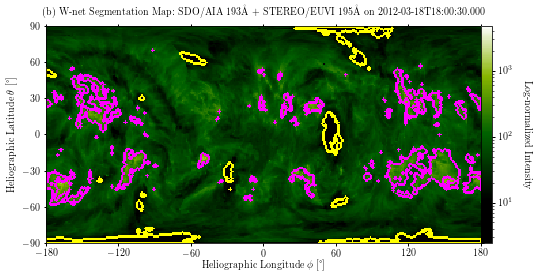

In [10]:
# Figure
frame = 0
font_size = 10
figsize_x = 8.0
figsize_y = 4.0
x_label = r'Heliographic Longitude $\phi$ [°]'
y_label = r'Heliographic Latitude $\theta$ [°]'
colorbar_cmap = plt.get_cmap('sohoeit195')  # 'eit195' # 'GnBu_r'
colorbar_label = r'Log-normalized Intensity'
# title_label = 'IBIS'
plt.rcParams["font.family"] = "Times New Roman"

vmin = np.nanmin(10.**ref_data)
vmax = np.nanmax(10.**ref_data)

ref_data_w = skimage.measure.block_reduce(ref_data,
                                    (10, 10), np.nanmin)
where_badpix_w = np.where(ref_data_w < lower_threshold)
ref_data_w[where_badpix_w] = np.nan

nx_w = int(nx/10)
ny_w = int(ny/10)
x = np.linspace(0, 360.0, ny_w)-180.0
y = np.linspace(0, 180.0, nx_w)-90.0

ref_data_w = 10.**ref_data_w


thickness = 2
z = np.zeros((nx_w, ny_w))
output = np.zeros((nx_w, ny_w))
arr = chs_w
for i in range(1, thickness):
    xp = np.concatenate((z[:i, :], arr[0:nx_w-i, :]), axis=0)
    xm = np.concatenate((arr[i:, :], z[nx_w-i:, :]), axis=0)
    yp = np.concatenate((z[:, :i], arr[:, 0:ny_w-i]), axis=1)
    ym = np.concatenate((arr[:, i:], z[:, ny_w-i:]), axis=1)
    ii = np.where(arr + xp == 1)
    output[ii] = 1
    ii = np.where(arr + xm == 1)
    output[ii] = 1
    ii = np.where(arr + yp == 1)
    output[ii] = 1
    ii = np.where(arr + ym == 1)
    output[ii] = 1
chs_masked = np.ma.masked_where(output == 0, output)
# chs_masked = np.ma.masked_where(wnet[0, :, :] == 0, output)

z = np.zeros((nx_w, ny_w))
output = np.zeros((nx_w, ny_w))
arr = ars_w
for i in range(1, thickness):
    xp = np.concatenate((z[:i, :], arr[0:nx_w-i, :]), axis=0)
    xm = np.concatenate((arr[i:, :], z[nx_w-i:, :]), axis=0)
    yp = np.concatenate((z[:, :i], arr[:, 0:ny_w-i]), axis=1)
    ym = np.concatenate((arr[:, i:], z[:, ny_w-i:]), axis=1)
    ii = np.where(arr + xp == 1)
    output[ii] = 1
    ii = np.where(arr + xm == 1)
    output[ii] = 1
    ii = np.where(arr + yp == 1)
    output[ii] = 1
    ii = np.where(arr + ym == 1)
    output[ii] = 1
ars_masked = np.ma.masked_where(output == 0, output)

z = np.zeros((nx_w, ny_w))
output = np.zeros((nx_w, ny_w))
arr = ext_w
for i in range(1, thickness):
    xp = np.concatenate((z[:i, :], arr[0:nx_w-i, :]), axis=0)
    xm = np.concatenate((arr[i:, :], z[nx_w-i:, :]), axis=0)
    yp = np.concatenate((z[:, :i], arr[:, 0:ny_w-i]), axis=1)
    ym = np.concatenate((arr[:, i:], z[:, ny_w-i:]), axis=1)
    ii = np.where(arr + xp == 1)
    output[ii] = 1
    ii = np.where(arr + xm == 1)
    output[ii] = 1
    ii = np.where(arr + yp == 1)
    output[ii] = 1
    ii = np.where(arr + ym == 1)
    output[ii] = 1
ext_masked = np.ma.masked_where(output == 0, output)

# chs_masked = np.ma.masked_where(chs_w == 1, output)
# ars_masked = np.ma.masked_where(ars_w == 1, output)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x, figsize_y))
I = ax.imshow(ref_data_w, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax))    
I2 = ax.imshow(chs_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
I3 = ax.imshow(ars_masked, extent=[min(x), max(x), min(y), max(y)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
I4 = ax.imshow(ext_masked, extent=[min(x), max(x), min(y), max(y)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
ax.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
ax.set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
ax.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
ax.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
ax.get_xaxis().set_major_locator(plt.MultipleLocator(60))
ax.get_yaxis().set_major_locator(plt.MultipleLocator(30))
# Title
ax.set_title(r'(b) W-net Segmentation Map: SDO/AIA 193Å + STEREO/EUVI 195Å on '+caplan_times[file_start], fontsize=font_size, y=1.02, wrap=True)
# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0)
cb = colorbar(I, extend='neither', cax=cax)
cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
cb.set_label(colorbar_label, labelpad=20.0, rotation=270, size=font_size)
# plt.savefig('Fig_Wnet_segmentation_map_lognorm.png', format='png', dpi=300)
plt.savefig('Fig_Wnet_segmentation_map_lognorm-2.png', format='png', dpi=250)
plt.draw()

# PSI, K-means, and W-net: Comparison

## Predictions combined into a single plot:

In [ ]:
# K-means
nx = 1600
ny = 3200
kmeans = pickle.load(open("save_Kmeans_lb_15i_6c.pkl", "rb"))
ch_cluster = 3
ar_cluster = 2
lower_threshold = -1.

# W-net
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
filenames_wnet = sorted(glob.glob(path_wnet))
nx_w = 160
ny_w = 320
filename = 'wnet_metrics_291120.npz'
tmp = np.load(filename)
ssim_arr_w = tmp['ssim_arr']
iou_arr_w = tmp['iou_arr']
ssim_filt_arr_w = tmp['ssim_filt_arr']
iou_filt_arr_w = tmp['iou_filt_arr']

# Files to read
file_start = 2000  # 2556  # 0
file_end = len(filenames_euv)-1  # 2557  # len(filenames_euv)

# Arrays
# ssim_arr = np.zeros((file_end-file_start))
# iou_arr = np.zeros((file_end-file_start))
# ssim_filt_arr = np.zeros((file_end-file_start))
# iou_filt_arr = np.zeros((file_end-file_start))

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):

    # Read EUV data
    euv_ref = read_hdf(filenames_euv[i]).astype(float)
    where_goodpix = np.where(euv_ref > lower_threshold)
    where_badpix = np.where(euv_ref < lower_threshold)
    # Make Kmeans prediciton
    clusters = make_kmeans_prediction(kmeans, euv_ref, lower_threshold=lower_threshold)
    # Extract CHs
    chs_k = np.where(clusters == ch_cluster, 1., 0.)
    ars_k = np.where(clusters == ar_cluster, 1., 0.)
    
    # Compare to Caplan CH masks 
    chs_ref = read_hdf(filenames_chm[i]).astype(float)
    chs_ref = np.where((chs_ref > 0) & (chs_ref < 10), 1., 0.)
    # Compute metrics
    ssim_arr = ssim(chs_ref, chs_k, data_range=chs_ref.max() - chs_ref.min())
    iou_arr = intersection_union(chs_ref, chs_k)
    ssim_filt_arr = ssim(chs_ref[where_goodpix], chs_k[where_goodpix], data_range=chs_ref[where_goodpix].max() - chs_ref[where_goodpix].min())
    iou_filt_arr = intersection_union(chs_ref[where_goodpix], chs_k[where_goodpix])
    
    # W-net
    f_images = h5py.File(filenames_wnet[i], 'r')
    clusters_wnet = f_images.get('Wnet+CRF')
    clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
    ii = np.where(clusters_wnet != 5 )
    chs_w = np.ones((nx_w, ny_w))
    chs_w[ii] = 0
    ii = np.where(clusters_wnet != 12 )
    ars_w = np.ones((nx_w, ny_w))
    ars_w[ii] = 0
    ii = np.where(clusters_wnet != 15 )
    ext_w = np.ones((nx_w, ny_w))
    ext_w[ii] = 0
    
    
    # Figure
    frame = 0
    font_size = 10
    figsize_x = 20.0
    figsize_y = 4.0
    x_label = r'Heliographic Longitude $\phi$ [°]'
    y_label = r'Heliographic Latitude $\theta$ [°]'
    colorbar_cmap = plt.get_cmap('sohoeit195')
    colorbar_label = r'Log-normalized Intensity'
    # title_label = 'IBIS'
    plt.rcParams["font.family"] = "Times New Roman"
    
    x = np.linspace(0, 360.0, ny)-180.0
    y = np.linspace(0, 180.0, nx)-90.0
    
    # Background
    euv_w = skimage.measure.block_reduce(euv_ref, (10, 10), np.nanmin)
    euv_ref[where_badpix] = np.nan
    vmin = 1.  # np.nanmin(10.**euv_ref)
    vmax = 3000  # np.nanmax(10.**euv_ref)
    euv_ref_log = 10.**euv_ref
    
    # Ref
    thickness = 10
    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = chs_ref
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_ref_masked = np.ma.masked_where(output == 0, output)

    # K-means
    thickness = 10
    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = chs_k
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_k_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = ars_k
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ars_k_masked = np.ma.masked_where(output == 0, output)
    
    # W-net
    where_badpix_w = np.where(euv_w < lower_threshold)
    euv_w[where_badpix_w] = np.nan

    x_w = np.linspace(0, 360.0, ny_w)-180.0
    y_w = np.linspace(0, 180.0, nx_w)-90.0

    euv_w_log = 10.**euv_w

    thickness = 2
    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w))
    arr = chs_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_w_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w)) 
    arr = ars_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ars_w_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w))
    arr = ext_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ext_w_masked = np.ma.masked_where(output == 0, output)

    fig = plt.figure(figsize=(figsize_x, figsize_y))
    spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1.00, 1.00, 1.025], height_ratios=[1], wspace=0.06,
                             hspace=0.0)
    ax0 = fig.add_subplot(spec[0, 0])
    I00 = ax0.imshow(euv_ref_log, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I01 = ax0.imshow(chs_ref_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0)  
    ax0.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    ax0.set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    ax0.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax0.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax0.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax0.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    date, ext = caplan_times[i].split('.')
    ax0.set_title(r'(a) Reference: SDO/AIA 193Å + STEREO/EUVI 195Å on '+date, fontsize=font_size, y=1.02, wrap=True)
    ax1 = fig.add_subplot(spec[0, 1])
    I10 = ax1.imshow(euv_ref_log, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I11 = ax1.imshow(chs_k_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
    I12 = ax1.imshow(ars_k_masked, extent=[min(x), max(x), min(y), max(y)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    ax1.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    # ax[1].set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    plt.setp(ax1.get_yticklabels(), visible=False)
    ax1.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax1.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax1.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax1.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    ax1.set_title(r'(b) K-means Segmentation Map: SSIM={0:.2f}, IoU={1:.2f}'.format(ssim_filt_arr, iou_filt_arr), fontsize=font_size, y=1.02, wrap=True)
    ax2 = fig.add_subplot(spec[0, 2])
    I20 = ax2.imshow(euv_w_log, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I21 = ax2.imshow(chs_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
    I22 = ax2.imshow(ars_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    I23 = ax2.imshow(ext_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    ax2.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    # ax[2].set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax2.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax2.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax2.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    ax2.set_title(r'(c) W-net Segmentation Map: SSIM={0:.2f}, IoU={1:.2f}'.format(ssim_filt_arr_w[i], iou_filt_arr_w[i]), fontsize=font_size, y=1.02, wrap=True)
    # Colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="2.5%", pad=0)
    cb = colorbar(I20, extend='neither', cax=cax)
    cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
    cb.set_label(colorbar_label, labelpad=15, rotation=270, size=font_size)
    # cb = fig.colorbar(I20, ax=ax[2], orientation="vertical")
    # cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
    # cb.set_label(colorbar_label, labelpad=20.0, rotation=270, size=font_size)
    # Save
    # plt.tight_layout()
    # plt.subplots_adjust(wspace=0.01)
    plt.draw()
    dir_name, filename = filenames_wnet[i].split('/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/')
    prefix, suffix = filename.split('.hdf5')
    # filename = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
    filename = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/plots2/'+prefix+'.png'
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close(fig)

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/btremblay/PycharmProjects/DeepVel_Latest/venv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.flo

### High-resolution version of the previous plot:

In [9]:
# K-means
nx = 1600
ny = 3200
kmeans = pickle.load(open("save_Kmeans_lb_15i_6c.pkl", "rb"))
ch_cluster = 3
ar_cluster = 2
lower_threshold = -1.

# W-net
path_wnet = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
filenames_wnet = sorted(glob.glob(path_wnet))
nx_w = 160
ny_w = 320
filename = 'wnet_metrics_291120.npz'
tmp = np.load(filename)
ssim_arr_w = tmp['ssim_arr']
iou_arr_w = tmp['iou_arr']
ssim_filt_arr_w = tmp['ssim_filt_arr']
iou_filt_arr_w = tmp['iou_filt_arr']

# Files to read
file_start = 2556  # 0
file_end = 2557  # len(filenames_euv)

# Arrays
# ssim_arr = np.zeros((file_end-file_start))
# iou_arr = np.zeros((file_end-file_start))
# ssim_filt_arr = np.zeros((file_end-file_start))
# iou_filt_arr = np.zeros((file_end-file_start))

# Plot images and print percentage of coronal holes in each image band
for i in range(file_start, file_end):

    # Read EUV data
    euv_ref = read_hdf(filenames_euv[i]).astype(float)
    where_goodpix = np.where(euv_ref > lower_threshold)
    where_badpix = np.where(euv_ref < lower_threshold)
    # Make Kmeans prediciton
    clusters = make_kmeans_prediction(kmeans, euv_ref, lower_threshold=lower_threshold)
    # Extract CHs
    chs_k = np.where(clusters == ch_cluster, 1., 0.)
    ars_k = np.where(clusters == ar_cluster, 1., 0.)
    
    # Compare to Caplan CH masks 
    chs_ref = read_hdf(filenames_chm[i]).astype(float)
    chs_ref = np.where((chs_ref > 0) & (chs_ref < 10), 1., 0.)
    # Compute metrics
    ssim_arr = ssim(chs_ref, chs_k, data_range=chs_ref.max() - chs_ref.min())
    iou_arr = intersection_union(chs_ref, chs_k)
    ssim_filt_arr = ssim(chs_ref[where_goodpix], chs_k[where_goodpix], data_range=chs_ref[where_goodpix].max() - chs_ref[where_goodpix].min())
    iou_filt_arr = intersection_union(chs_ref[where_goodpix], chs_k[where_goodpix])
    
    # W-net
    f_images = h5py.File(filenames_wnet[i], 'r')
    clusters_wnet = f_images.get('Wnet+CRF')
    clusters_wnet = np.reshape(clusters_wnet, (nx_w, ny_w))
    ii = np.where(clusters_wnet != 5 )
    chs_w = np.ones((nx_w, ny_w))
    chs_w[ii] = 0
    ii = np.where(clusters_wnet != 12 )
    ars_w = np.ones((nx_w, ny_w))
    ars_w[ii] = 0
    ii = np.where(clusters_wnet != 15 )
    ext_w = np.ones((nx_w, ny_w))
    ext_w[ii] = 0
    
    
    # Figure
    frame = 0
    font_size = 20
    figsize_x = 40.0
    figsize_y = 8.0
    x_label = r'Heliographic Longitude $\phi$ [°]'
    y_label = r'Heliographic Latitude $\theta$ [°]'
    colorbar_cmap = plt.get_cmap('sohoeit195')
    colorbar_label = r'Log-normalized Intensity'
    # title_label = 'IBIS'
    plt.rcParams["font.family"] = "Times New Roman"
    
    x = np.linspace(0, 360.0, ny)-180.0
    y = np.linspace(0, 180.0, nx)-90.0
    
    # Background
    euv_w = skimage.measure.block_reduce(euv_ref, (10, 10), np.nanmin)
    euv_ref[where_badpix] = np.nan
    vmin = 1.  # np.nanmin(10.**euv_ref)
    vmax = 3000  # np.nanmax(10.**euv_ref)
    euv_ref_log = 10.**euv_ref
    
    # Ref
    thickness = 10
    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = chs_ref
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_ref_masked = np.ma.masked_where(output == 0, output)

    # K-means
    thickness = 10
    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = chs_k
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_k_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    arr = ars_k
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ars_k_masked = np.ma.masked_where(output == 0, output)
    
    # W-net
    where_badpix_w = np.where(euv_w < lower_threshold)
    euv_w[where_badpix_w] = np.nan

    x_w = np.linspace(0, 360.0, ny_w)-180.0
    y_w = np.linspace(0, 180.0, nx_w)-90.0

    euv_w_log = 10.**euv_w

    thickness = 2
    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w))
    arr = chs_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    chs_w_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w)) 
    arr = ars_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ars_w_masked = np.ma.masked_where(output == 0, output)

    z = np.zeros((nx_w, ny_w))
    output = np.zeros((nx_w, ny_w))
    arr = ext_w
    for j in range(1, thickness):
        xp = np.concatenate((z[:j, :], arr[0:nx_w-j, :]), axis=0)
        xm = np.concatenate((arr[j:, :], z[nx_w-j:, :]), axis=0)
        yp = np.concatenate((z[:, :j], arr[:, 0:ny_w-j]), axis=1)
        ym = np.concatenate((arr[:, j:], z[:, ny_w-j:]), axis=1)
        ii = np.where(arr + xp == 1)
        output[ii] = 1
        ii = np.where(arr + xm == 1)
        output[ii] = 1
        ii = np.where(arr + yp == 1)
        output[ii] = 1
        ii = np.where(arr + ym == 1)
        output[ii] = 1
    ext_w_masked = np.ma.masked_where(output == 0, output)

    fig = plt.figure(figsize=(figsize_x, figsize_y))
    spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1.00, 1.00, 1.025], height_ratios=[1], wspace=0.06,
                             hspace=0.0)
    ax0 = fig.add_subplot(spec[0, 0])
    I00 = ax0.imshow(euv_ref_log, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I01 = ax0.imshow(chs_ref_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0)  
    ax0.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    ax0.set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    ax0.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax0.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax0.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax0.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    date, ext = caplan_times[i].split('.')
    ax0.set_title(r'(a) Reference: SDO/AIA 193Å + STEREO/EUVI 195Å on '+date, fontsize=font_size, y=1.02, wrap=True)
    ax1 = fig.add_subplot(spec[0, 1])
    I10 = ax1.imshow(euv_ref_log, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I11 = ax1.imshow(chs_k_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
    I12 = ax1.imshow(ars_k_masked, extent=[min(x), max(x), min(y), max(y)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    ax1.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    # ax[1].set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    plt.setp(ax1.get_yticklabels(), visible=False)
    ax1.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax1.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax1.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax1.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    ax1.set_title(r'(b) K-means Segmentation Map: SSIM={0:.2f}, IoU={1:.2f}'.format(ssim_filt_arr, iou_filt_arr), fontsize=font_size, y=1.02, wrap=True)
    ax2 = fig.add_subplot(spec[0, 2])
    I20 = ax2.imshow(euv_w_log, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), aspect='equal')   
    I21 = ax2.imshow(chs_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
    I22 = ax2.imshow(ars_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    I23 = ax2.imshow(ext_w_masked, extent=[min(x_w), max(x_w), min(y_w), max(y_w)], cmap='cool_r', interpolation='none', origin='lower', alpha=1.0) 
    ax2.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    # ax[2].set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax2.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax2.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax2.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    ax2.set_title(r'(c) W-net Segmentation Map: SSIM={0:.2f}, IoU={1:.2f}'.format(ssim_filt_arr_w[i], iou_filt_arr_w[i]), fontsize=font_size, y=1.02, wrap=True)
    # Colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="2.5%", pad=0)
    cb = colorbar(I20, extend='neither', cax=cax)
    cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
    cb.set_label(colorbar_label, labelpad=15, rotation=270, size=font_size)
    # cb = fig.colorbar(I20, ax=ax[2], orientation="vertical")
    # cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
    # cb.set_label(colorbar_label, labelpad=20.0, rotation=270, size=font_size)
    # Save
    # plt.tight_layout()
    # plt.subplots_adjust(wspace=0.01)
    plt.draw()
    dir_name, filename = filenames_wnet[i].split('/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/')
    prefix, suffix = filename.split('.hdf5')
    # filename = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/WNet_SEARCH/output/maps*'
    # filename = '/media/btremblay/My Passport/dir.Files/dir.Backups/dir.EUV/caplan/plots2/'+prefix+'.png'
    filename = 'NeurIPS_segmentation_map_upres3.png'
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    filename = 'NeurIPS_segmentation_map_upres3.eps'
    plt.savefig(filename, format='eps', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close(fig)